# P7 - Implémentez un modèle de scoring

Objectif : Aider la société "Prêt à dépenser", organisme octroyant des crédits à des personnes y ayant difficilement accès, en créant un modèle de classification permettant de prédire la probabilité de défaut d'un client sur un crédit et de pouvoir aider à la prise de décision. 

Il s'agit d'un problème de classification supervisée où l'on dispose d'un jeu de données "train" avec target étiquetée et un jeu de test sans la target.

On dispose de 8 jeu de données. Certains concernent les emprunts précédents des clients auprès d'Home Credit d'autres des données provenant d'institutions extérieures. Il s'agit à la fois de données administratives et comportementales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## EDA

On s'inspirera ici des kernels kaggle suivant pour l'analyse de données et la création de certaines features :

* https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook
* https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [3]:
# Import des jeu de données application train et test :

path = "F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Données projet/"

In [4]:
filename = "application_test.csv"
test_df = pd.read_csv(path + filename)
test_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test_df.shape

(48744, 121)

On a 48744 lignes et 121 colonnes dans le jeu de données application_test.

In [6]:
filename = "application_train.csv"
train_df = pd.read_csv(path + filename)
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_df.shape

(307511, 122)

On a 307 511 lignes dans le jeu de données train et une colonne supplémentaire, la Target, comparé au jeu de données test.

### Analyse jeu de données train

In [8]:
# Distribution de la target :

train_df['TARGET'].value_counts(normalize=True) * 100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

In [9]:
target_count = train_df['TARGET'].value_counts()

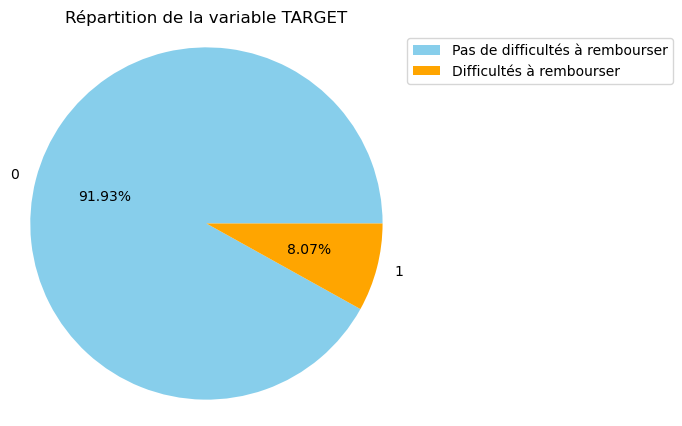

In [10]:
# Visualisation de la distribution de la target:

# On crée un pie chart
plt.figure(figsize=(5,5))
plt.pie(target_count, labels=target_count.index, autopct='%1.2f%%', colors=['skyblue', 'orange'])
plt.title('Répartition de la variable TARGET')
plt.legend(labels=['Pas de difficultés à rembourser', 'Difficultés à rembourser'], loc='best', bbox_to_anchor=(1,1))
plt.axis('equal') 

# Afficher le pie chart
plt.show()

On voit qu'on est bien dans un problème de classification avec des données très déséquilibrées au niveau de la variable à prédire, 92% de 0 pour 8% de 1.

### Point sur les valeurs manquantes

In [11]:
# Création d'une fonction permettant de visualiser les valeurs manquantes :

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table = mis_val_table[
            mis_val_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Le dataframe a " + str(df.shape[1]) + " columns.\n"      
            "Et il y a " + str(mis_val_table.shape[0]) +
              " colonnes ayant des valeurs manquantes.")
        
        # Return the dataframe with missing information
        return mis_val_table

In [12]:
# Valeurs manquants dans le jeu de données train :

miss_val_table_train = missing_values_table(train_df)

Le dataframe a 122 columns.
Et il y a 67 colonnes ayant des valeurs manquantes.


In [13]:
miss_val_table_train.head(20)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


On voit que certaines colonnes ont un taux de valeurs manquantes assez important, à plus de 50 %. Cela concerne principalement des informations sur le lieu d'habitation des clients.

<Axes: >

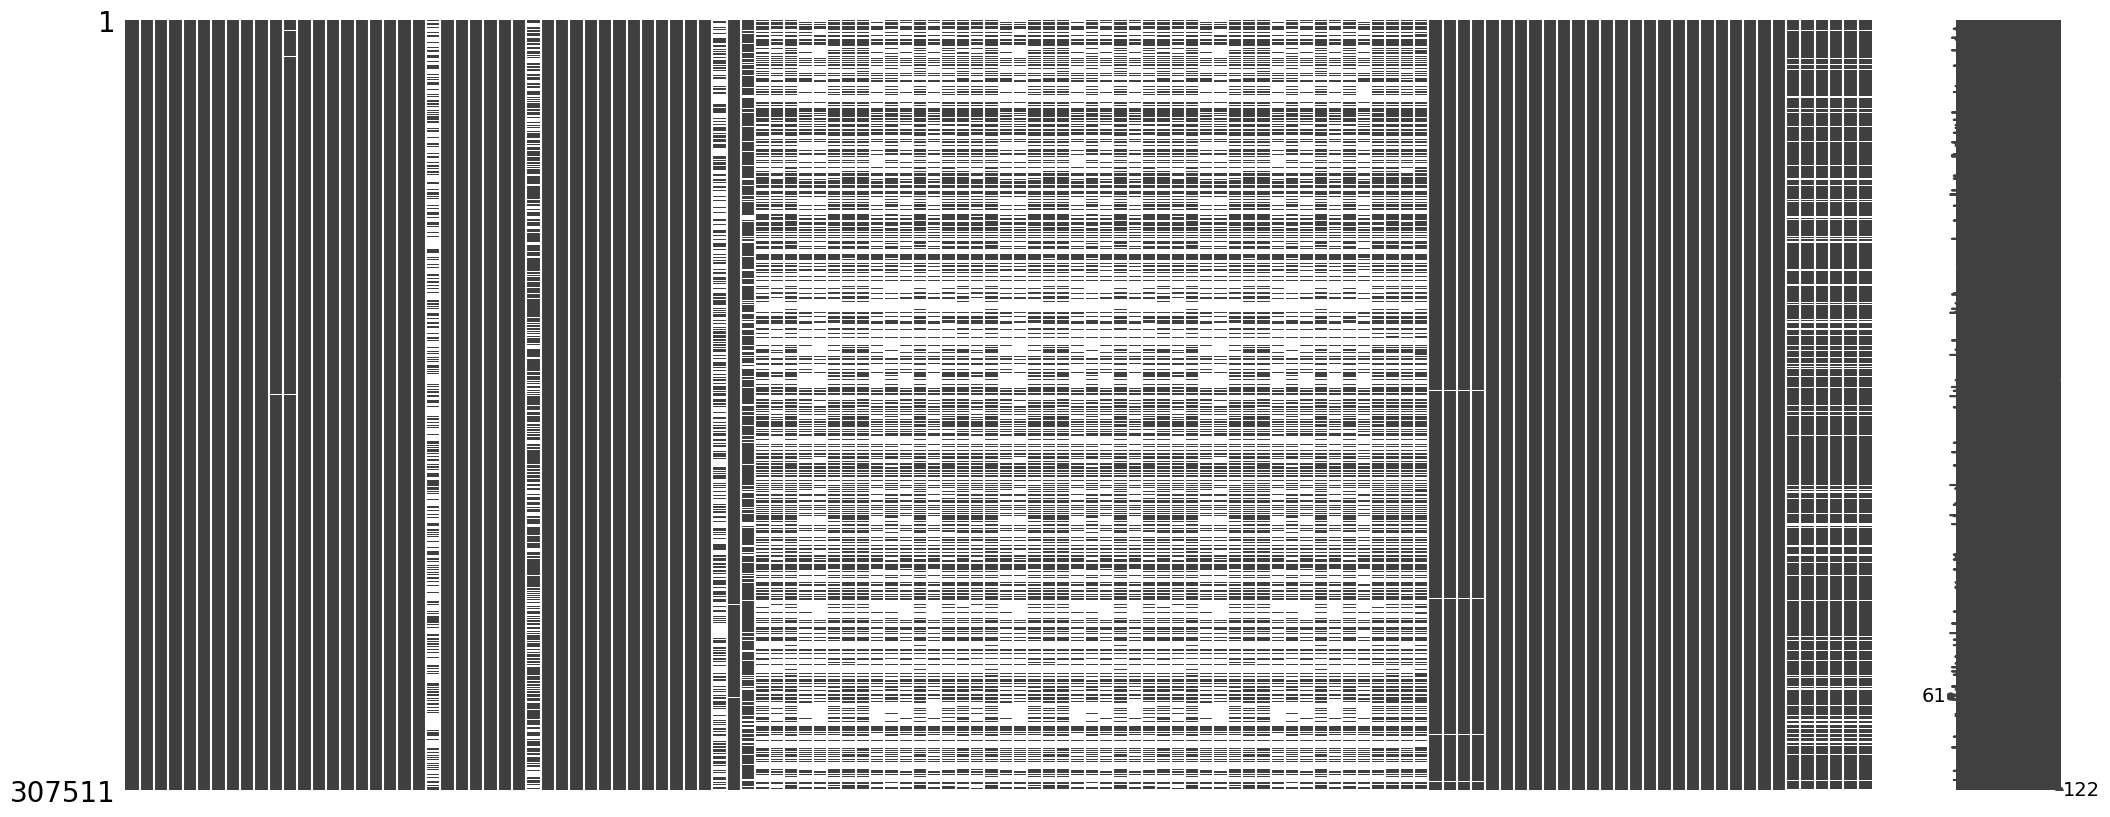

In [14]:
msno.matrix(train_df)

Certaines colonnes ont l'air à l'inverse bien remplies.

<Axes: >

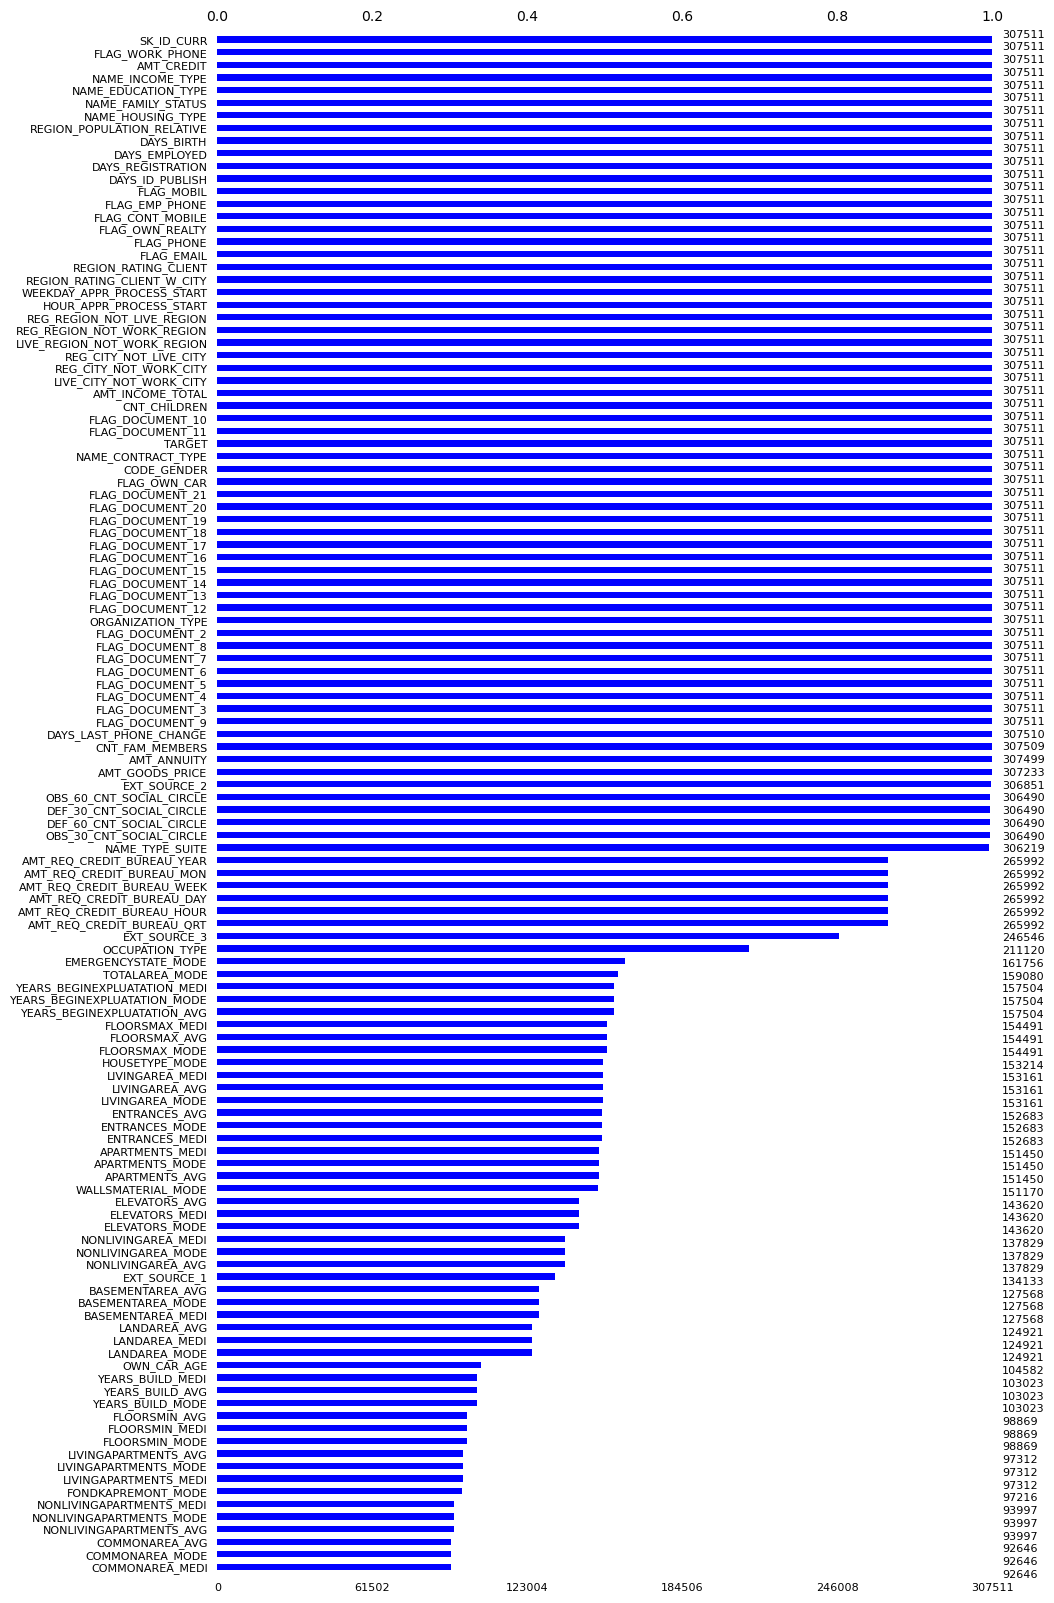

In [15]:
msno.bar(train_df, figsize=(10,20), fontsize=8, sort='ascending', color='blue')

In [16]:
miss_val_table_train[miss_val_table_train["% of Total Values"]>=50].shape[0]

41

On a 41 colonnes ayant 50% ou plus de valeurs manquantes.

In [17]:
display(miss_val_table_train[miss_val_table_train["% of Total Values"]>=50])

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


On décide de conserver les colonnes 'Ext Sources' qui correspondent à des scores sur les emprunteurs provenant d'autres institutions financières. On supprime les colonnes ayant plus de 50% de valeurs manquantes sinon.

In [18]:
# On crée une fonction car il nous faudra appliquer la même chose au test_df :

def delete_nan(df, seuil, col_to_keep = ['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3']):
    """Fonction qui permet de supprimer les colonnes ayant un taux de valeurs manquantes supérieur à un seuil à fixer
    On choisit de conserver certaines des colonnes malgré tout pour notre analyse : col_to_keep
    
    df : Dataframe que l'on souhaite nettoyer,
    seuil : seuil de valeurs manquantes par colonnes au-delà duquel les colonnes seront supprimées,
    col_to_keep : exception, colonnes qu'on souhaite conserver
    
    retourne un dataframe nettoyé"""

    missing_values = df.isna().mean()
    list_delete = list(missing_values[missing_values > seuil].index)

    for col in col_to_keep:
        if col in list_delete:
            list_delete.remove(col)
    print(f"Suppression de {len(list_delete)} colonnes car elles contenaient trop de valeurs manquantes.")
    df.drop(list_delete, axis=1, inplace=True)

    return df, list_delete


In [19]:
train_df, train_delete = delete_nan(train_df, 0.5)

Suppression de 40 colonnes car elles contenaient trop de valeurs manquantes.


In [20]:
miss_val_table_train = missing_values_table(train_df)

Le dataframe a 82 columns.
Et il y a 27 colonnes ayant des valeurs manquantes.


In [21]:
miss_val_table_train.head()

,Missing Values,% of Total Values
EXT_SOURCE_1,173378,56.4
FLOORSMAX_MEDI,153020,49.8
FLOORSMAX_AVG,153020,49.8
FLOORSMAX_MODE,153020,49.8
YEARS_BEGINEXPLUATATION_AVG,150007,48.8


Nous poursuivons l'analyse et reviendrons aux valaurs manquantes par la suite, l'idée sera de réaliser une imputation par la médiane pour les variables numériques et une imputation par la modalité la plus fréquente pour les variables catégorielles.

### Variables atypiques/aberrantes

In [22]:
train_df.describe().round(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00,307511.00,307511.00,3.075110e+05,307511.00,307499.00,307233.00,307511.00,307511.00,307511.00,...,307511.00,307511.00,307511.00,307511.00,265992.00,265992.00,265992.00,265992.00,265992.00,265992.00
mean,278180.52,0.08,0.42,1.687979e+05,599026.00,27108.57,538396.21,0.02,-16037.00,63815.05,...,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.27,0.27,1.90
std,102790.18,0.27,0.72,2.371231e+05,402490.78,14493.74,369446.46,0.01,4363.99,141275.77,...,0.09,0.02,0.02,0.02,0.08,0.11,0.20,0.92,0.79,1.87
min,100002.00,0.00,0.00,2.565000e+04,45000.00,1615.50,40500.00,0.00,-25229.00,-17912.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,189145.50,0.00,0.00,1.125000e+05,270000.00,16524.00,238500.00,0.01,-19682.00,-2760.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,278202.00,0.00,0.00,1.471500e+05,513531.00,24903.00,450000.00,0.02,-15750.00,-1213.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,367142.50,0.00,1.00,2.025000e+05,808650.00,34596.00,679500.00,0.03,-12413.00,-289.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
max,456255.00,1.00,19.00,1.170000e+08,4050000.00,258025.50,4050000.00,0.07,-7489.00,365243.00,...,1.00,1.00,1.00,1.00,4.00,9.00,8.00,27.00,261.00,25.00


On peut noter une incohérence dans la variable 'Days_Employed' qui prend des valeurs négatives (exprimés en jour travaillés avant de contracter un emprunt) sauf pour le maximum.

<Axes: ylabel='Frequency'>

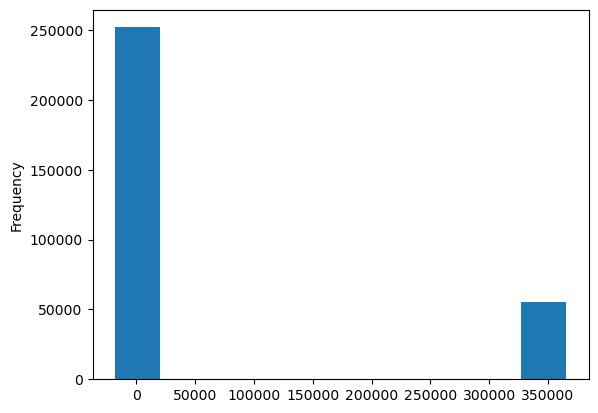

In [23]:
train_df['DAYS_EMPLOYED'].plot.hist()

<Axes: ylabel='Frequency'>

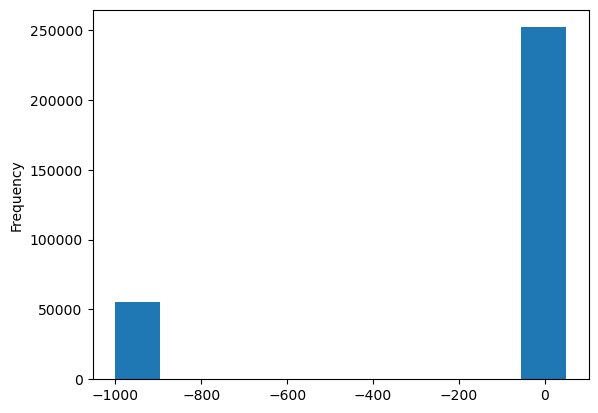

In [24]:
# Pour plus de lisibilité on crée une variable qui correspond à cette données exprimée en années et avec des valeurs positives :
train_df['YEARS_EMPLOYED'] = -train_df['DAYS_EMPLOYED'] / 365
train_df['YEARS_EMPLOYED'].plot.hist()

On remplace les valeurs incohérentes par des Nan. On voit qu'elles concernent tout de même + de 50000 individus.

In [25]:
# On peut garder trace de l'anomalie en créant une colonne binaire :
train_df['ANOM_YEARS_EMPLOYED'] = np.where(train_df['YEARS_EMPLOYED'] < -900, 1,0)

# On remplace les valeurs anormales dans la variables initiales par des Nan :
train_df['YEARS_EMPLOYED'] = np.where(train_df['YEARS_EMPLOYED'] < -900, np.nan,train_df['YEARS_EMPLOYED'])

<Axes: ylabel='Frequency'>

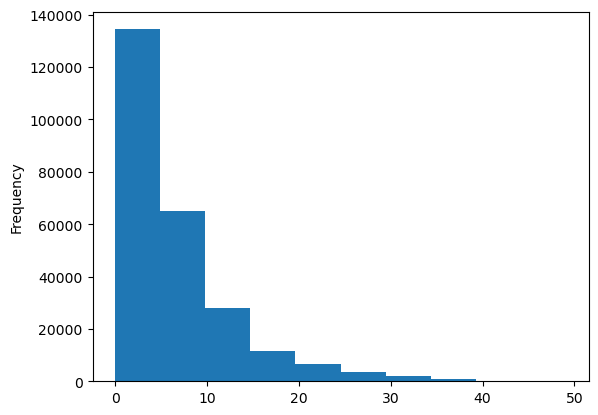

In [26]:
# On a maintenant une distribution plus cohérente :
train_df['YEARS_EMPLOYED'].plot.hist()

De la même manière la variable 'DAYS_BIRTH' est exprimée en valeurs négatives, c'est le nombre de jours entre la naissance et la date de la contraction de l'emprunt.

<Axes: ylabel='Frequency'>

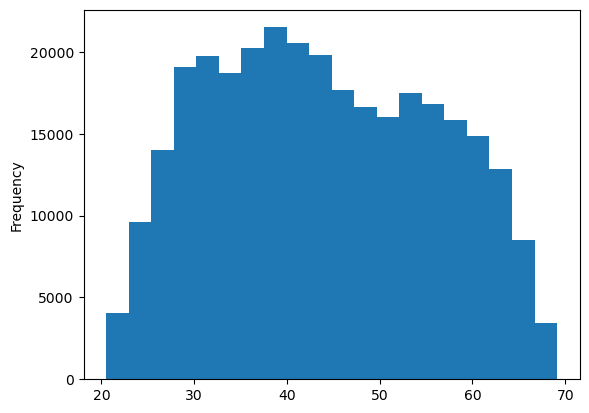

In [27]:
# Pour plus de lisibilité on crée une variable qui correspond à cette données exprimée en années et avec des valeurs positives :
train_df['YEARS_BIRTH'] = -train_df['DAYS_BIRTH'] / 365
train_df['YEARS_BIRTH'].plot.hist(bins=20)

On voit que cette transformation nous donne une distribution des âges plutôt cohérente.

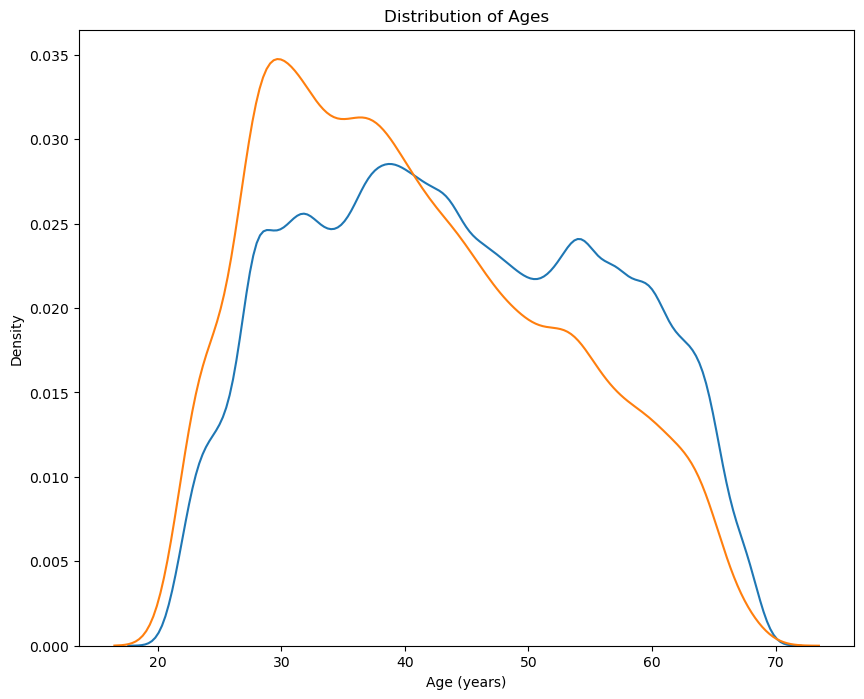

In [28]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'YEARS_BIRTH'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'YEARS_BIRTH'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

plt.show()

In [29]:
ages_df = train_df[['YEARS_BIRTH', 'TARGET']]
# Bin the age data
ages_df['YEARS_BINNED'] = pd.cut(ages_df['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
ages_df.head(10)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_14412\3503125945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages_df['YEARS_BINNED'] = pd.cut(ages_df['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,YEARS_BIRTH,TARGET,YEARS_BINNED
0,25.920548,1,"(25.0, 30.0]"
1,45.931507,0,"(45.0, 50.0]"
2,52.180822,0,"(50.0, 55.0]"
3,52.068493,0,"(50.0, 55.0]"
4,54.608219,0,"(50.0, 55.0]"
5,46.413699,0,"(45.0, 50.0]"
6,37.747945,0,"(35.0, 40.0]"
7,51.643836,0,"(50.0, 55.0]"
8,55.065753,0,"(55.0, 60.0]"
9,39.641096,0,"(35.0, 40.0]"


In [30]:
# Group by the bin and calculate averages
age_groups  = ages_df.groupby('YEARS_BINNED').mean()
age_groups

,YEARS_BIRTH,TARGET
YEARS_BINNED,,
"(20.0, 25.0]",23.377522,0.123036
"(25.0, 30.0]",27.822518,0.111436
"(30.0, 35.0]",32.479037,0.102814
"(35.0, 40.0]",37.555913,0.089414
"(40.0, 45.0]",42.459346,0.078491
"(45.0, 50.0]",47.462741,0.074171
"(50.0, 55.0]",52.593136,0.066968
"(55.0, 60.0]",57.491131,0.055314
"(60.0, 65.0]",62.412459,0.052737


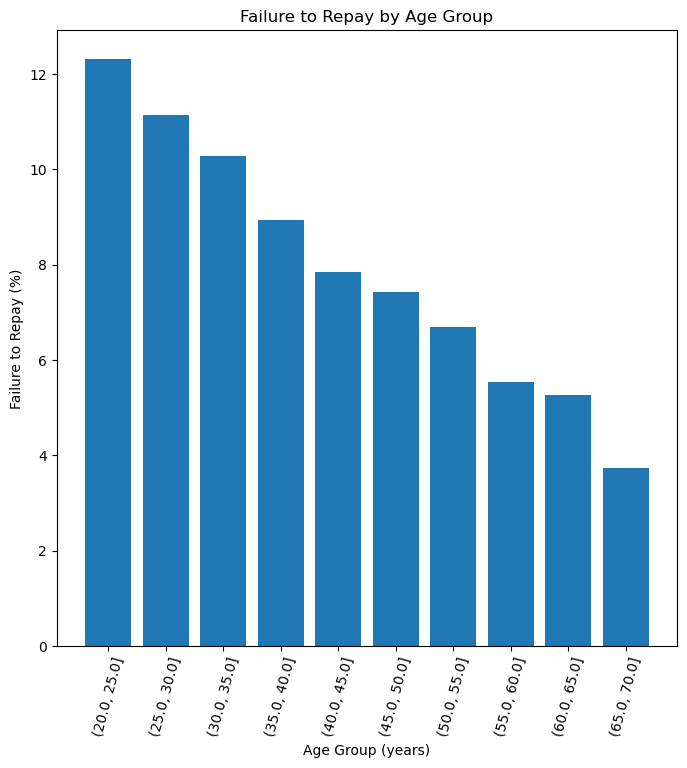

In [31]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75) 
plt.xlabel('Age Group (years)') 
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')
plt.show()

On voit que l'âge peut avoir un impact sur la difficulté à rembourser son emprunt. 

Le max de la variable 'CNT_CHILDREN' paraît étonnant.

<Axes: >

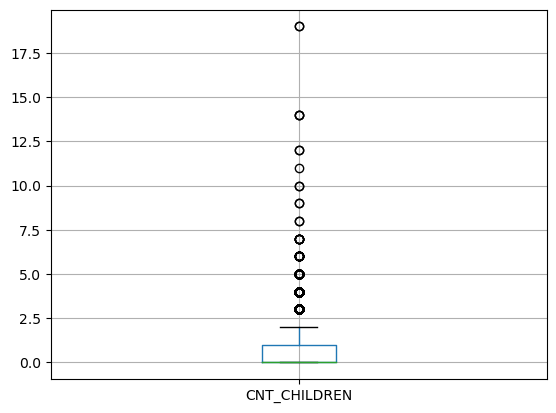

In [32]:
train_df[['CNT_CHILDREN']].boxplot()

In [33]:
train_df.loc[train_df['CNT_CHILDREN'] >= 5, ['SK_ID_CURR', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']].sort_values('CNT_CHILDREN', ascending = False).head(40)

,SK_ID_CURR,CNT_CHILDREN,CNT_FAM_MEMBERS
155369,280108,19,20.0
265784,407877,19,20.0
267998,410527,14,16.0
183878,313127,14,16.0
176011,303956,14,15.0
80948,193853,12,14.0
171125,298322,12,14.0
34545,140032,11,13.0
132585,253779,10,12.0
186820,316580,10,12.0


A priori il n'y a pas d'incohérences avec la variable comptant le nombre de membres de famille donc on conserve les individus concernés.

<Axes: >

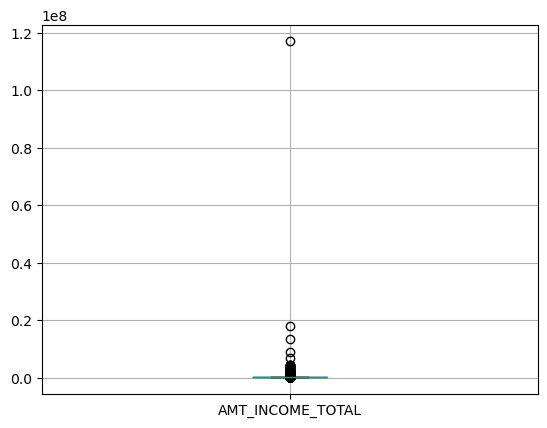

In [34]:
train_df[['AMT_INCOME_TOTAL']].boxplot()

In [35]:
train_df.loc[train_df['AMT_INCOME_TOTAL'].argmax(), ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'CODE_GENDER', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE']]

SK_ID_CURR                                    114967
AMT_INCOME_TOTAL                         117000000.0
CODE_GENDER                                        F
OCCUPATION_TYPE                             Laborers
ORGANIZATION_TYPE             Business Entity Type 3
NAME_EDUCATION_TYPE    Secondary / secondary special
Name: 12840, dtype: object

In [36]:
fem_lab_medincome = train_df.loc[(train_df['CODE_GENDER']=='F') &  (train_df['OCCUPATION_TYPE']=='Laborers'), 'AMT_INCOME_TOTAL'].median()

On peut considérer qu'il s'agit d'une erreur de saisi et qu'il y a trois 0 de trop.

In [37]:
train_df.loc[train_df['AMT_INCOME_TOTAL'].argmax(), 'AMT_INCOME_TOTAL'] = 117000

<Axes: >

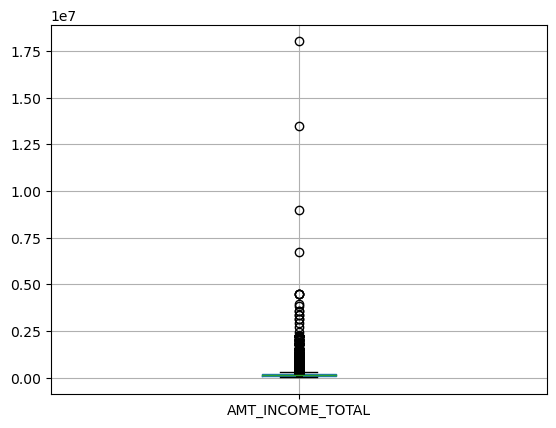

In [38]:
train_df[['AMT_INCOME_TOTAL']].boxplot()

<Axes: >

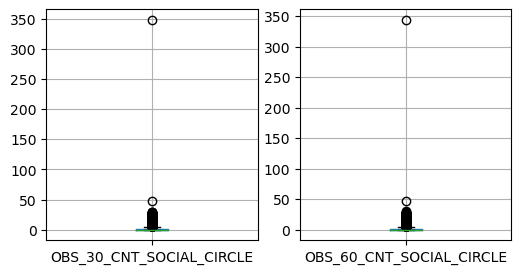

In [39]:
# 348 et 344 semblent très élevés pour 30 CNT et 60 CNT - aberrant (nb of observation of client's social surroundings)
fig, axs = plt.subplots(1,2,figsize=(6,3))

train_df[["OBS_30_CNT_SOCIAL_CIRCLE"]].boxplot(ax=axs[0])
train_df[["OBS_60_CNT_SOCIAL_CIRCLE"]].boxplot(ax=axs[1])

In [40]:
train_df.loc[train_df['OBS_30_CNT_SOCIAL_CIRCLE'].argmax(), ['SK_ID_CURR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']]

SK_ID_CURR                  272071
OBS_30_CNT_SOCIAL_CIRCLE     348.0
OBS_60_CNT_SOCIAL_CIRCLE     344.0
Name: 148403, dtype: object

Les valeurs incohérentes concernent ici le même individu, on le supprime de l'échantillon.

In [41]:
train_df.drop(train_df['OBS_60_CNT_SOCIAL_CIRCLE'].argmax(), axis =0, inplace=True)

Le 'describe' nous montrait une valeur étonnamment élevée pour la variable 'AMT_REQ_CREDIT_BUREAU_QRT', surtout comparé à celle mensuelle ou annuelle.

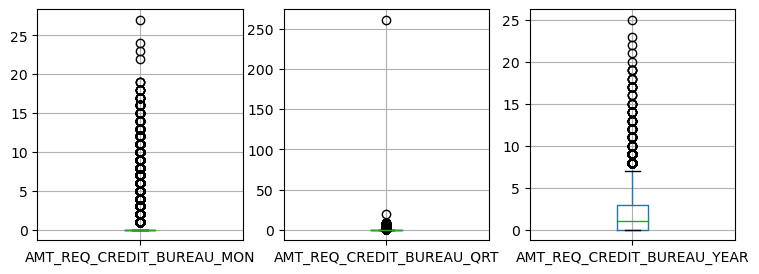

In [42]:
fig, axs = plt.subplots(1,3, figsize=(9, 3))

train_df[['AMT_REQ_CREDIT_BUREAU_MON']].boxplot(ax=axs[0])
train_df[['AMT_REQ_CREDIT_BUREAU_QRT']].boxplot(ax=axs[1])
train_df[['AMT_REQ_CREDIT_BUREAU_YEAR']].boxplot(ax=axs[2])
plt.show()

In [43]:
# Je supprime l'individu concerné :
train_df.drop(train_df['AMT_REQ_CREDIT_BUREAU_QRT'].argmax(), axis = 0, inplace = True)

#### Corrélation avec la target :

In [44]:
# Find correlations with the target and sort
correlations = train_df.select_dtypes(include='number').corr()
corr_target = correlations["TARGET"].sort_values(ascending=False)

# Display correlations
print('Most Negative Correlations:\n', corr_target.tail(15))
print('\nMost Positive Correlations:\n', corr_target.head(15))

Most Negative Correlations:
 FLAG_DOCUMENT_6              -0.028603
AMT_CREDIT                   -0.030371
TOTALAREA_MODE               -0.032598
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039647
FLOORSMAX_MODE               -0.043226
FLOORSMAX_MEDI               -0.043767
FLOORSMAX_AVG                -0.044003
DAYS_EMPLOYED                -0.044933
ANOM_YEARS_EMPLOYED          -0.045988
YEARS_EMPLOYED               -0.074958
YEARS_BIRTH                  -0.078241
EXT_SOURCE_1                 -0.155319
EXT_SOURCE_2                 -0.160474
EXT_SOURCE_3                 -0.178919
Name: TARGET, dtype: float64

Most Positive Correlations:
 TARGET                         1.000000
DAYS_BIRTH                     0.078241
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055217
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050999
FLAG_EMP_PHONE                 0.045983
REG_CIT

Les niveaux de corrélations ne sont pas très élevés, ce sont les scores provenant d'institutions financières qui sont les plus corrélés avec la TARGET.

In [45]:
# Extract top correlated variables with the target and show correlations :
ext_data = train_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155319,-0.160474,-0.178919,0.078241
EXT_SOURCE_1,-0.155319,1.000000,0.213979,0.186843,-0.600608
EXT_SOURCE_2,-0.160474,0.213979,1.000000,0.109169,-0.091991
EXT_SOURCE_3,-0.178919,0.186843,0.109169,1.000000,-0.205476
DAYS_BIRTH,0.078241,-0.600608,-0.091991,-0.205476,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

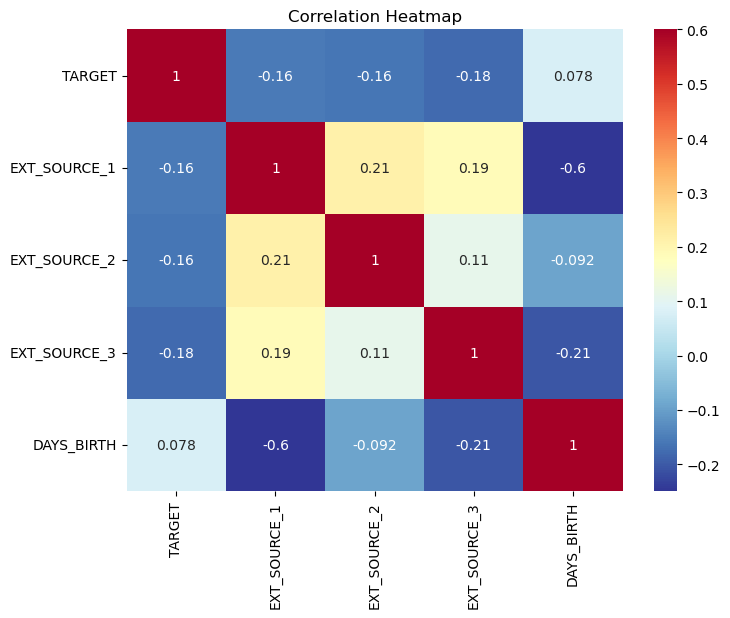

In [46]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

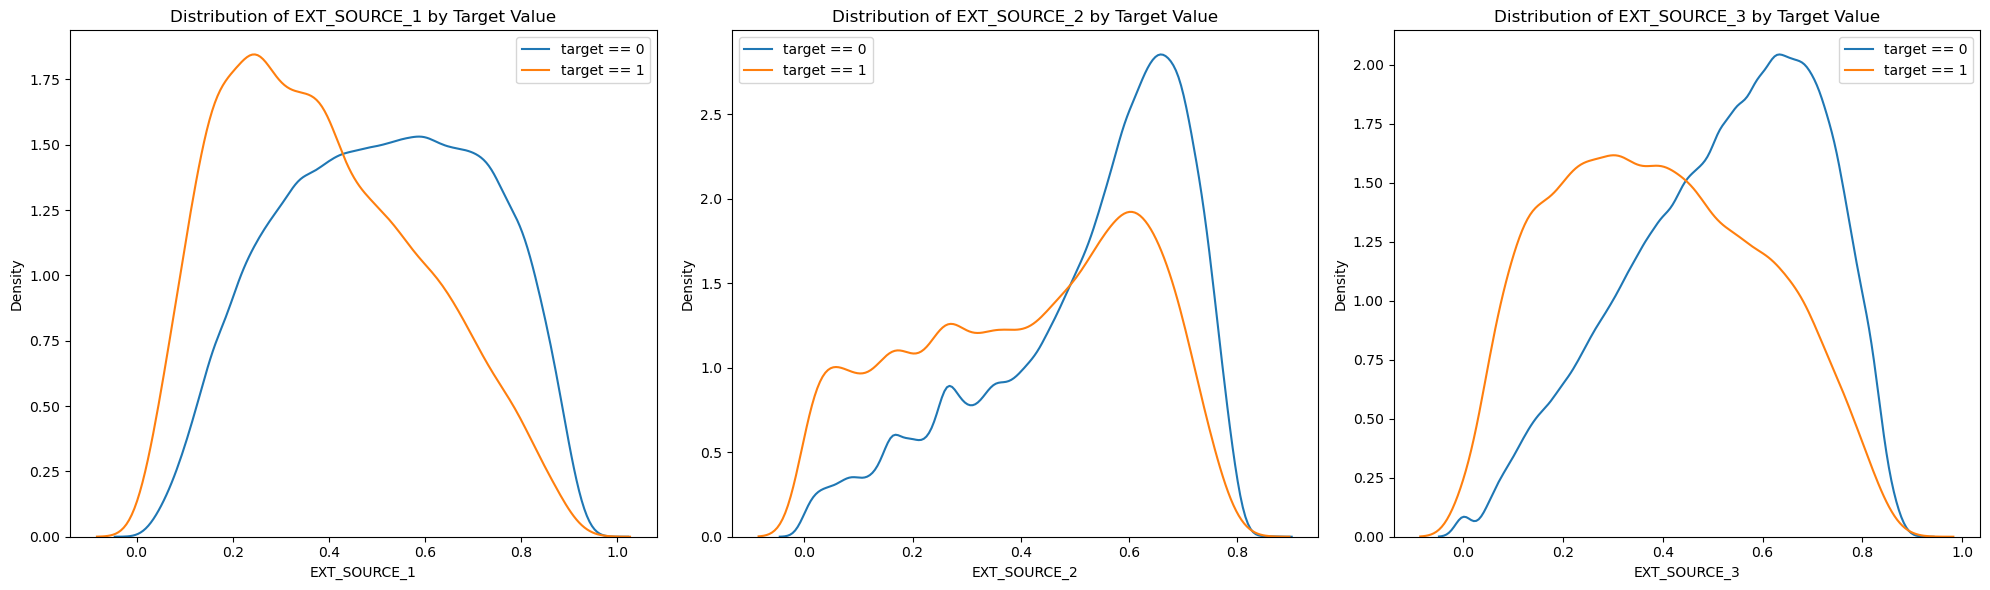

In [47]:
plt.figure(figsize = (20, 6))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(1, 3, i + 1)
    # plot repaid loans
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title(f'Distribution of {source} by Target Value')
    plt.xlabel(f'{source}'); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

On voit que c'est le score 3 qui est le plus impactant par rapport à la TARGET.

#### Variables catégorielles

In [48]:
train_df.dtypes.value_counts()

int64      41
float64    30
object     13
int32       1
Name: count, dtype: int64

On voit qu'on a 13 variables catégorielles.

In [49]:
train_df.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart ont un nombre de modalités assez faibles, la majorité a un nombre inférieur à 10, seulement 2 variables en ont plus.

On voit qu'on a 3 modalités pour gender :

In [50]:
train_df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202447
M      105058
XNA         4
Name: count, dtype: int64

In [51]:
# Je supprime les observations où XNA est renseigné :

train_df = train_df[train_df['CODE_GENDER']!='XNA']

In [52]:
train_df['CODE_GENDER'].value_counts()

CODE_GENDER
F    202447
M    105058
Name: count, dtype: int64

In [53]:
# Y a-t-il d'autres colonnes ou XNA est indiqué ?

columns_with_XNA = []

for col in train_df.columns:
    if 'XNA' in train_df[col].values:
        columns_with_XNA.append(col)

print("Colonnes contenant 'XNA' :", columns_with_XNA)

Colonnes contenant 'XNA' : ['ORGANIZATION_TYPE']


In [54]:
train_df['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67991
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2340
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

Je pense qu'en l'occurrence ce XNA peut s'assimilier à du 'unknown', je vais donc le transformer en données manquantes.

In [55]:
train_df['ORGANIZATION_TYPE'] = np.where(train_df['ORGANIZATION_TYPE']=='XNA', np.nan, train_df['ORGANIZATION_TYPE'])

#### Création de features

In [56]:
# revenu par personne dans le foyer
train_df["INCOME_PER_PERSON"] = train_df["AMT_INCOME_TOTAL"] / train_df["CNT_FAM_MEMBERS"]

# ratio annuités / revenu
train_df["ANNUITY_AS_INCOME_PERC"] = train_df["AMT_ANNUITY"] / train_df["AMT_INCOME_TOTAL"]

# taux de remboursement par annuité
train_df["PAYMENT_RATE"] = train_df["AMT_ANNUITY"] / train_df["AMT_CREDIT"]

# montant du crédit par rapport au revenu
train_df["CREDIT_INCOME_RATIO"] = train_df["AMT_CREDIT"] / train_df["AMT_INCOME_TOTAL"]

# montant de l'achat financé personnellement
train_df["DOWN_PAYMENT"] = train_df["AMT_GOODS_PRICE"] - train_df["AMT_CREDIT"]

# part de la durée de vie occupée à travailler
train_df["EMPLOYMENT_AGE_RATIO"] =  train_df["YEARS_EMPLOYED"] / train_df["YEARS_BIRTH"]

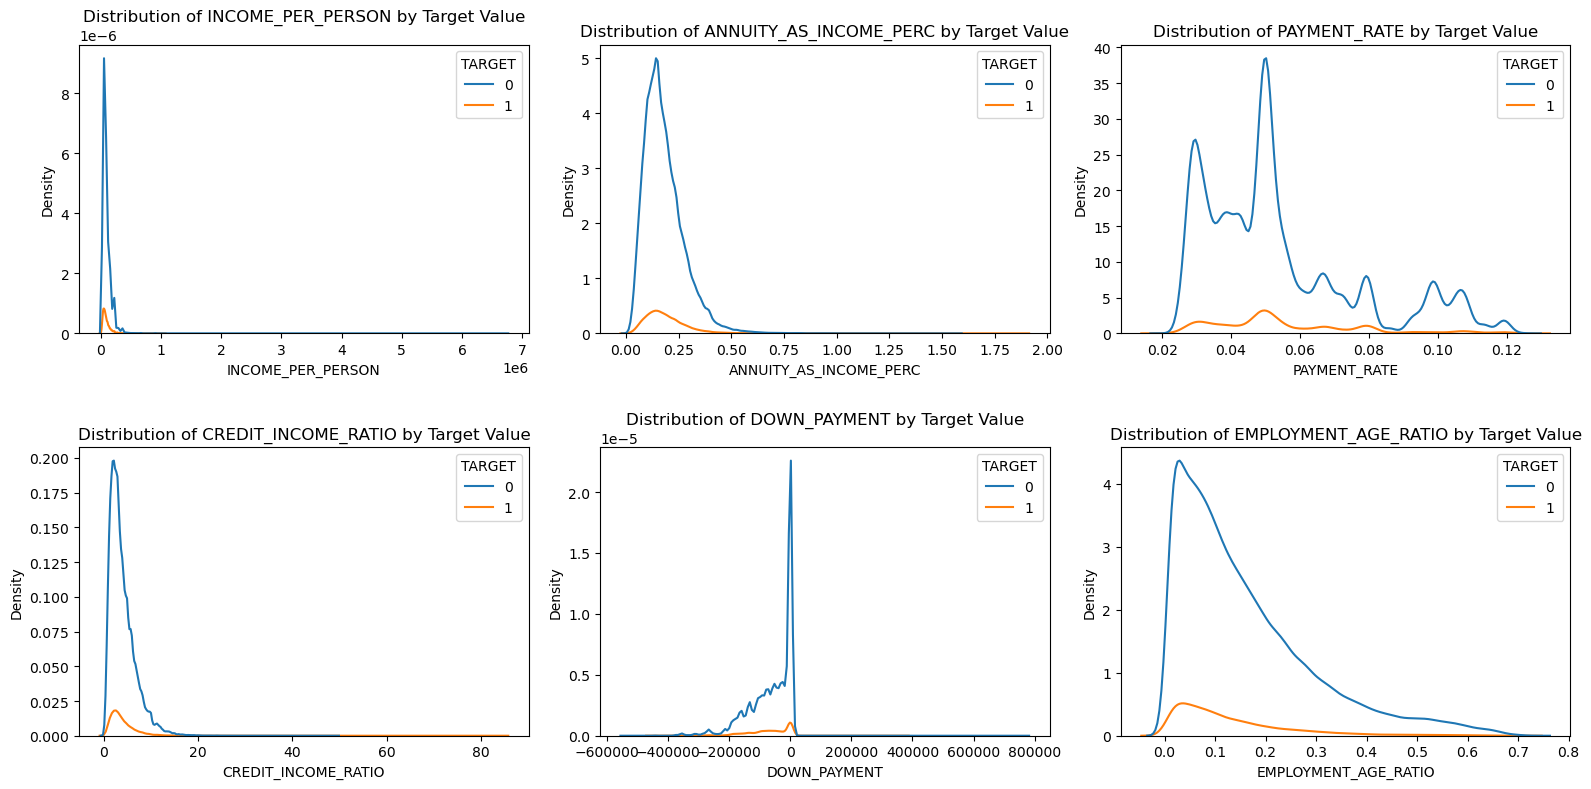

In [57]:
# Corrélation des nouvelles variables avec la target :

plt.figure(figsize = (16, 8))

# on sélectionne les nouvelles variables:
for i, new_feat in enumerate(['INCOME_PER_PERSON', 'ANNUITY_AS_INCOME_PERC', 'PAYMENT_RATE', 'CREDIT_INCOME_RATIO', 'DOWN_PAYMENT', 'EMPLOYMENT_AGE_RATIO']):
    
    # on crée un graphique pour chaque nouvelle variable:
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=train_df, x=new_feat, hue='TARGET')
    plt.title(f'Distribution of {new_feat} by Target Value')
    plt.xlabel(f'{new_feat}'); plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

In [58]:
# On peut supprimer les variables DAYS_BIRTH et DAYS_EMPLOYED :
train_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

In [59]:
train_df.shape

(307505, 89)

#### Encodage des variables catégorielles

In [60]:
# L'idée est d'encoder par Label Encoder les variables catégorielles ayant au maximum 2 modalités et d'encoder les autres par onehotencoder :

def cat_encoding(df):
    """Encodage des variables catégorielles : label encoder si nb modalités <=2, ohe sinon
    
    Args : df -> dataframe avec variables à encoder
    retourne un dataframe avec variables encodés"""

    label_enc = LabelEncoder()
    cat_col = list(df.select_dtypes('object').columns)
    le_col = [col for col in cat_col if df[col].nunique() <= 2]
    ohe_col = [col for col in cat_col if col not in le_col]

    # Transformation par Label Endoding :
    for col in le_col:
        label_enc.fit(df[col])
        df[col] = label_enc.transform(df[col])

    # Transformation par ohe via pd.get_dummies :
    df_enc = pd.get_dummies(df[ohe_col], dummy_na=True).astype('int')
    df_newcol = df.drop(ohe_col, axis = 1)
    df_newcol = df_newcol.join(df_enc)

    return df_newcol

In [61]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_EMPLOYED,ANOM_YEARS_EMPLOYED,YEARS_BIRTH,INCOME_PER_PERSON,ANNUITY_AS_INCOME_PERC,PAYMENT_RATE,CREDIT_INCOME_RATIO,DOWN_PAYMENT,EMPLOYMENT_AGE_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,1.745205,0,25.920548,202500.0,0.121978,0.060749,2.007889,-55597.5,0.067329
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,3.254795,0,45.931507,135000.0,0.132217,0.027598,4.790750,-164002.5,0.070862
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.616438,0,52.180822,67500.0,0.100000,0.050000,2.000000,0.0,0.011814
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,8.326027,0,52.068493,67500.0,0.219900,0.094941,2.316167,-15682.5,0.159905
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,8.323288,0,54.608219,121500.0,0.179963,0.042623,4.222222,0.0,0.152418


Avant de procéder à cet encodage nous devons imputer les valeurs manquantes. L'idée est d'imputer les variables numériques par la médiane et les variables catégorielle par la modalité la plus fréquente.

In [62]:
def impute_nan(df):
    """Fonction d'imputation des données manquantes :
    - impute les variables numériques par leur médiane
    - impute les variables catégorielles par la modalité la plus fréquente
    
    Args : df -> dataframe où l'on souhaite imputer les valeurs manquantes
    """

    cat_var = list(df.select_dtypes('object').columns)
    num_var = [col for col in list(df.columns) if col not in cat_var]

    missing = df.isna().sum()
    list_feat = list(missing[missing>0].index)

    for feat in list_feat:
        if feat in cat_var:
            df[feat] = df[feat].fillna(df[feat].mode()[0])
        elif feat in num_var:
            df[feat] = df[feat].fillna(df[feat].median())
        else: print("Erreur")
    print(f"Vérification présence données manquantes après imputation :{df.isna().sum().sum()}")

In [63]:
impute_nan(train_df)

Vérification présence données manquantes après imputation :0


In [64]:
train_df.shape

(307505, 89)

In [65]:
train_df = cat_encoding(train_df)

In [66]:
train_df.shape

(307505, 203)

In [67]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_nan
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [68]:
nb_init_feat = train_df.drop('TARGET', axis=1).shape[1]

### Données provenant d'autres institutions financières

In [69]:
filename = "bureau.csv"
bureau = pd.read_csv(path + filename)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [70]:
bureau.shape

(1716428, 17)

Le jeu de données 'bureau' contient 1 716 428 lignes et 17 colonnes. Il contient donc des informations sur des crédits réalisés par les clients de l'échantillon HomeCredit auprès d'autres institutions financières. 

Il s'agira ici de créer des variables par crédits puis par clients, grâce à des aggrégations de types moyennes, max, min, somme ou comptage d'occurrences afin de pouvoir ensuite regrouper ce dataframe avec le dataframe principal.

In [71]:
bureau['SK_ID_CURR'].nunique()

305811

Le dataset contient des infos pour 305811 clients uniques.

On regarde aussi le dataset bureau_balance car il sera nécessaire de regrouper ces 2 jeux de données :

In [72]:
filename = "bureau_balance.csv"
bureau_balance = pd.read_csv(path + filename)
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [73]:
bureau_balance.shape

(27299925, 3)

Ce dataset décrit le statut d'un crédit à une période donnée.

In [74]:
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


Concernant la variable 'Months_Balance', les données les + récentes prennent la valeur 0 et les plus anciennes des valeurs négatives de plus en plus faibles.

In [75]:
bureau_balance['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

La variable STATUS peut prendre 8 valeurs. Beaucoup de crédits sont clôturés ou ont un statut inconnu

In [76]:
# Il peut être intéressant de récupérer le statut du crédit le plus récent :
most_recent_loan = bureau_balance.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].max()

In [77]:
most_recent_loan

,SK_ID_BUREAU,MONTHS_BALANCE
0,5001709,0
1,5001710,0
2,5001711,0
3,5001712,0
4,5001713,0
...,...,...
817390,6842884,0
817391,6842885,0
817392,6842886,0
817393,6842887,0


In [78]:
most_recent_loan_status = pd.merge(most_recent_loan, bureau_balance, how='left', on = ['SK_ID_BUREAU', 'MONTHS_BALANCE'])
most_recent_loan_status.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5001709,0,C
1,5001710,0,C
2,5001711,0,X
3,5001712,0,C
4,5001713,0,X


In [79]:
most_recent_loan_status.shape

(817395, 3)

In [80]:
most_recent_loan_status.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,8.173950e+05,817395.000000
mean,6.022974e+06,-7.034154
std,5.007138e+05,17.026851
min,5.001709e+06,-96.000000
25%,5.700076e+06,-1.000000
50%,6.061126e+06,0.000000
75%,6.430106e+06,0.000000
max,6.842888e+06,0.000000


In [81]:
# Durée du crédit :
duration_last_loan = bureau_balance.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].min()
duration_last_loan

,SK_ID_BUREAU,MONTHS_BALANCE
0,5001709,-96
1,5001710,-82
2,5001711,-3
3,5001712,-18
4,5001713,-21
...,...,...
817390,6842884,-47
817391,6842885,-23
817392,6842886,-32
817393,6842887,-36


In [82]:
duration_last_loan.rename(columns={'MONTHS_BALANCE' : 'BB_LAST_LOAN_DURATION'}, inplace=True)
duration_last_loan.head()

,SK_ID_BUREAU,BB_LAST_LOAN_DURATION
0,5001709,-96
1,5001710,-82
2,5001711,-3
3,5001712,-18
4,5001713,-21


In [83]:
# On regroupe les 2 dataframes :

bb_tmp = pd.merge(duration_last_loan, most_recent_loan_status, how = 'left', on= 'SK_ID_BUREAU')
bb_tmp.head()

,SK_ID_BUREAU,BB_LAST_LOAN_DURATION,MONTHS_BALANCE,STATUS
0,5001709,-96,0,C
1,5001710,-82,0,C
2,5001711,-3,0,X
3,5001712,-18,0,C
4,5001713,-21,0,X


In [84]:
# Je renomme certaines colonnes pour identifier le df de base : 
bb_tmp.rename(columns={'MONTHS_BALANCE' : 'BB_MONTHS_TILL_END', 'STATUS' : 'BB_STATUS'}, inplace = True)
bb_tmp.head()

,SK_ID_BUREAU,BB_LAST_LOAN_DURATION,BB_MONTHS_TILL_END,BB_STATUS
0,5001709,-96,0,C
1,5001710,-82,0,C
2,5001711,-3,0,X
3,5001712,-18,0,C
4,5001713,-21,0,X


In [85]:
# Je supprime les df ne servant plus :
import gc
gc.enable()
del bureau_balance, most_recent_loan, most_recent_loan_status, duration_last_loan
gc.collect()

502

Bureau dataset

In [86]:
# merge avec dataset nouvellement créé :
bureau = pd.merge(bureau, bb_tmp, how='left', on='SK_ID_BUREAU')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,BB_LAST_LOAN_DURATION,BB_MONTHS_TILL_END,BB_STATUS
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN


Traitement spécifique des variables catégorielles : Credit Type et Credit Active

In [87]:
def count_categorical(df, group_var, vars_to_consider):
    """Computes counts for each observation
    of `group_var` of each unique category in vars_to_consider variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns
    
    vars_to_consider : list(string)
        Categorical variables we want to transform

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts of each unique category in vars_to_consider variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df[vars_to_consider]).astype('int')

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var, as_index=False).sum()
    
    return categorical

In [88]:
list_vars = ['CREDIT_ACTIVE', 'CREDIT_TYPE']
categorical_bureau = count_categorical(bureau, 'SK_ID_CURR', list_vars)
categorical_bureau.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100001,3,0,4,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
1,100002,2,0,6,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0
2,100003,1,0,3,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0
3,100004,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
4,100005,2,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0


In [89]:
# Sélectionnez les colonnes à renommer
cols_to_rename = [col for col in categorical_bureau.columns if col.startswith(('CREDIT_ACTIVE_', 'CREDIT_TYPE_'))]

# Créer un dictionnaire de mappage pour les nouveaux noms de colonnes
rename_mapping = {
    **{col: col.replace('CREDIT_ACTIVE_', 'BURO_NB_CREDIT_') for col in cols_to_rename if col.startswith('CREDIT_ACTIVE_')},
    **{col: col.replace('CREDIT_TYPE_', 'BURO_NB_CDT_TYPE_') for col in cols_to_rename if col.startswith('CREDIT_TYPE_')}
}

# Renommer les colonnes
categorical_bureau.rename(columns=rename_mapping, inplace=True)

# Afficher les noms de colonnes mis à jour
print(categorical_bureau.columns)

Index(['SK_ID_CURR', 'BURO_NB_CREDIT_Active', 'BURO_NB_CREDIT_Bad debt',
       'BURO_NB_CREDIT_Closed', 'BURO_NB_CREDIT_Sold',
       'BURO_NB_CDT_TYPE_Another type of loan', 'BURO_NB_CDT_TYPE_Car loan',
       'BURO_NB_CDT_TYPE_Cash loan (non-earmarked)',
       'BURO_NB_CDT_TYPE_Consumer credit', 'BURO_NB_CDT_TYPE_Credit card',
       'BURO_NB_CDT_TYPE_Interbank credit',
       'BURO_NB_CDT_TYPE_Loan for business development',
       'BURO_NB_CDT_TYPE_Loan for purchase of shares (margin lending)',
       'BURO_NB_CDT_TYPE_Loan for the purchase of equipment',
       'BURO_NB_CDT_TYPE_Loan for working capital replenishment',
       'BURO_NB_CDT_TYPE_Microloan', 'BURO_NB_CDT_TYPE_Mobile operator loan',
       'BURO_NB_CDT_TYPE_Mortgage', 'BURO_NB_CDT_TYPE_Real estate loan',
       'BURO_NB_CDT_TYPE_Unknown type of loan'],
      dtype='object')


In [90]:
bureau['CNT_CREDIT_PROLONG'].describe()

count    1.716428e+06
mean     6.410406e-03
std      9.622391e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.000000e+00
Name: CNT_CREDIT_PROLONG, dtype: float64

In [91]:
# Création de nouvelles features, l'idée est d'aboutir à un dataframe où 1 ligne = 1 client:
loans_hist = bureau.groupby('SK_ID_CURR').agg({'SK_ID_CURR' : 'count', 'CREDIT_CURRENCY':'nunique', 'DAYS_CREDIT' : 'max', 'DAYS_CREDIT_ENDDATE' : 'max', 'DAYS_ENDDATE_FACT' : 'max',
                                               'AMT_CREDIT_MAX_OVERDUE' : 'sum', 'AMT_CREDIT_SUM' : 'sum', 'AMT_CREDIT_SUM_DEBT' : 'sum', 'AMT_CREDIT_SUM_OVERDUE' : 'sum',
                                               'CNT_CREDIT_PROLONG' : 'max', 'BB_LAST_LOAN_DURATION' : 'mean', 'BB_MONTHS_TILL_END' : 'mean'}).rename(columns={'SK_ID_CURR' : 'BURO_NB_CREDITS',
                                                                                                                      'CREDIT_CURRENCY' : 'BURO_NB_CURRENCY',
                                                                                                                      'DAYS_CREDIT' : 'BURO_DAYS_SINCE_LAST_CREDIT',
                                                                                                                      'DAYS_CREDIT_ENDDATE' : 'BURO_MAX_DAYS_REMAIN_CREDIT',
                                                                                                                      'DAYS_ENDDATE_FACT' : 'BURO_DAYS_SINCE_LAST_REFUND',
                                                                                                                      'AMT_CREDIT_MAX_OVERDUE' : 'BURO_MAX_OVERDUE',
                                                                                                                      'AMT_CREDIT_SUM_OVERDUE' : 'BURO_TOTAL_OVERDUE',
                                                                                                                      'AMT_CREDIT_SUM' : 'BURO_TOTAL_AMT_BORROWED',
                                                                                                                      'AMT_CREDIT_SUM_DEBT' : 'BURO_TOTAL_CURR_DEBT',
                                                                                                                      'CNT_CREDIT_PROLONG' : 'BURO_MAX_CREDIT_PROLONG',
                                                                                                                      'BB_LAST_LOAN_DURATION' : 'BB_LAST_LOAN_DURATION_MEAN'})

In [92]:
loans_hist.head()

,BURO_NB_CREDITS,BURO_NB_CURRENCY,BURO_DAYS_SINCE_LAST_CREDIT,BURO_MAX_DAYS_REMAIN_CREDIT,BURO_DAYS_SINCE_LAST_REFUND,BURO_MAX_OVERDUE,BURO_TOTAL_AMT_BORROWED,BURO_TOTAL_CURR_DEBT,BURO_TOTAL_OVERDUE,BURO_MAX_CREDIT_PROLONG,BB_LAST_LOAN_DURATION_MEAN,BB_MONTHS_TILL_END
SK_ID_CURR,,,,,,,,,,,,
100001,7,1,-49,1778.0,-544.0,0.000,1453365.000,596686.5,0.0,0,-23.571429,0.0
100002,8,1,-103,780.0,-36.0,8405.145,865055.565,245781.0,0.0,0,-28.250000,-15.5
100003,4,1,-606,1216.0,-540.0,0.000,1017400.500,0.0,0.0,0,NaN,NaN
100004,2,1,-408,-382.0,-382.0,0.000,189037.800,0.0,0.0,0,NaN,NaN
100005,3,1,-62,1324.0,-123.0,0.000,657126.000,568408.5,0.0,0,-6.000000,0.0


In [93]:
loans_hist.reset_index(inplace=True)
loans_hist.head()

,SK_ID_CURR,BURO_NB_CREDITS,BURO_NB_CURRENCY,BURO_DAYS_SINCE_LAST_CREDIT,BURO_MAX_DAYS_REMAIN_CREDIT,BURO_DAYS_SINCE_LAST_REFUND,BURO_MAX_OVERDUE,BURO_TOTAL_AMT_BORROWED,BURO_TOTAL_CURR_DEBT,BURO_TOTAL_OVERDUE,BURO_MAX_CREDIT_PROLONG,BB_LAST_LOAN_DURATION_MEAN,BB_MONTHS_TILL_END
0,100001,7,1,-49,1778.0,-544.0,0.000,1453365.000,596686.5,0.0,0,-23.571429,0.0
1,100002,8,1,-103,780.0,-36.0,8405.145,865055.565,245781.0,0.0,0,-28.250000,-15.5
2,100003,4,1,-606,1216.0,-540.0,0.000,1017400.500,0.0,0.0,0,NaN,NaN
3,100004,2,1,-408,-382.0,-382.0,0.000,189037.800,0.0,0.0,0,NaN,NaN
4,100005,3,1,-62,1324.0,-123.0,0.000,657126.000,568408.5,0.0,0,-6.000000,0.0


In [94]:
loans_hist['BURO_MAX_DAYS_REMAIN_CREDIT'].describe()

count    303226.000000
mean       4508.643464
std        9422.717152
min      -41875.000000
25%         126.000000
50%         912.000000
75%        1692.000000
max       31199.000000
Name: BURO_MAX_DAYS_REMAIN_CREDIT, dtype: float64

On peut supposer que les valeurs négatives de cette variable correspondent en fait à un prêt ayant été remboursé.

In [95]:
loans_hist['BURO_MAX_DAYS_REMAIN_CREDIT'] = np.where(loans_hist['BURO_MAX_DAYS_REMAIN_CREDIT']<0, 0, loans_hist['BURO_MAX_DAYS_REMAIN_CREDIT'])

In [96]:
loans_hist['BURO_MAX_DAYS_REMAIN_CREDIT'].describe()

count    303226.000000
mean       4656.818792
std        9339.138039
min           0.000000
25%         126.000000
50%         912.000000
75%        1692.000000
max       31199.000000
Name: BURO_MAX_DAYS_REMAIN_CREDIT, dtype: float64

In [97]:
# Je transforme la variable comptant le nombre de crédits prolongés en une variable binaire : 1 s'il y a déjà eu prolongation, 0 sinon :
loans_hist['BURO_MAX_CREDIT_PROLONG'] = np.where(loans_hist['BURO_MAX_CREDIT_PROLONG'].isna(), np.nan, np.where(loans_hist['BURO_MAX_CREDIT_PROLONG'] > 0, 1, 0))

In [98]:
bureau_df = pd.merge(loans_hist, categorical_bureau, how='left', on='SK_ID_CURR')
bureau_df.head()

,SK_ID_CURR,BURO_NB_CREDITS,BURO_NB_CURRENCY,BURO_DAYS_SINCE_LAST_CREDIT,BURO_MAX_DAYS_REMAIN_CREDIT,BURO_DAYS_SINCE_LAST_REFUND,BURO_MAX_OVERDUE,BURO_TOTAL_AMT_BORROWED,BURO_TOTAL_CURR_DEBT,BURO_TOTAL_OVERDUE,...,BURO_NB_CDT_TYPE_Interbank credit,BURO_NB_CDT_TYPE_Loan for business development,BURO_NB_CDT_TYPE_Loan for purchase of shares (margin lending),BURO_NB_CDT_TYPE_Loan for the purchase of equipment,BURO_NB_CDT_TYPE_Loan for working capital replenishment,BURO_NB_CDT_TYPE_Microloan,BURO_NB_CDT_TYPE_Mobile operator loan,BURO_NB_CDT_TYPE_Mortgage,BURO_NB_CDT_TYPE_Real estate loan,BURO_NB_CDT_TYPE_Unknown type of loan
0,100001,7,1,-49,1778.0,-544.0,0.000,1453365.000,596686.5,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100002,8,1,-103,780.0,-36.0,8405.145,865055.565,245781.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,100003,4,1,-606,1216.0,-540.0,0.000,1017400.500,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100004,2,1,-408,0.0,-382.0,0.000,189037.800,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,100005,3,1,-62,1324.0,-123.0,0.000,657126.000,568408.5,0.0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
bureau_df.shape

(305811, 32)

In [100]:
print(f"On a donc créé {bureau_df.shape[1]-1} nouvelles features grâce aux informations d'autres institutions financières.")

On a donc créé 31 nouvelles features grâce aux informations d'autres institutions financières.


In [101]:
# Comme pour application_train on va supprimer les colonnes dont le taux de valeurs manquantes est > 50% :
bureau_df, list_nan = delete_nan(bureau_df, 0.5)
list_nan

Suppression de 2 colonnes car elles contenaient trop de valeurs manquantes.


['BB_LAST_LOAN_DURATION_MEAN', 'BB_MONTHS_TILL_END']

In [102]:
impute_nan(bureau_df)

Vérification présence données manquantes après imputation :0


In [103]:
del bureau, bb_tmp, loans_hist
gc.collect()

31653

#### Données historiques des clients en interne

In [104]:
# Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit

filename = "POS_CASH_balance.csv"
cash = pd.read_csv(path + filename)
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [105]:
cash.shape

(10001358, 8)

In [106]:
cash['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: count, dtype: int64

In [107]:
cash = cash.loc[cash['NAME_CONTRACT_STATUS'] != 'XNA']

In [108]:
list_vars = ['NAME_CONTRACT_STATUS']
categorical_cash = count_categorical(cash, 'SK_ID_PREV', list_vars)
categorical_cash.head()

,SK_ID_PREV,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed
0,1000001,2,0,0,0,1,0,0,0
1,1000002,4,0,0,0,1,0,0,0
2,1000003,4,0,0,0,0,0,0,0
3,1000004,7,0,0,0,1,0,0,0
4,1000005,10,0,0,0,1,0,0,0


In [109]:
# Sélectionnez les colonnes à renommer
cols_to_rename = [col for col in categorical_cash.columns if col.startswith('NAME_CONTRACT_STATUS_')]

# Créer un dictionnaire de mappage pour les nouveaux noms de colonnes
rename_mapping = {
    col: col.replace('NAME_CONTRACT_STATUS_', 'CASH_STATUS_') for col in cols_to_rename if col.startswith('NAME_CONTRACT_STATUS_')
}

# Renommer les colonnes
categorical_cash.rename(columns=rename_mapping, inplace=True)

# Afficher les noms de colonnes mis à jour
print(categorical_cash.columns)

Index(['SK_ID_PREV', 'CASH_STATUS_Active', 'CASH_STATUS_Amortized debt',
       'CASH_STATUS_Approved', 'CASH_STATUS_Canceled', 'CASH_STATUS_Completed',
       'CASH_STATUS_Demand', 'CASH_STATUS_Returned to the store',
       'CASH_STATUS_Signed'],
      dtype='object')


In [110]:
categorical_cash

,SK_ID_PREV,CASH_STATUS_Active,CASH_STATUS_Amortized debt,CASH_STATUS_Approved,CASH_STATUS_Canceled,CASH_STATUS_Completed,CASH_STATUS_Demand,CASH_STATUS_Returned to the store,CASH_STATUS_Signed
0,1000001,2,0,0,0,1,0,0,0
1,1000002,4,0,0,0,1,0,0,0
2,1000003,4,0,0,0,0,0,0,0
3,1000004,7,0,0,0,1,0,0,0
4,1000005,10,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
936320,2843494,2,0,0,0,1,0,0,0
936321,2843495,7,0,0,0,1,0,0,0
936322,2843497,21,0,0,0,0,0,0,0
936323,2843498,6,0,0,0,1,0,0,0


In [111]:
most_recent_cash = cash.groupby("SK_ID_PREV", as_index=False)[["MONTHS_BALANCE"]].max()
most_recent_status = pd.merge(most_recent_cash, categorical_cash, how='left', on = 'SK_ID_PREV')
# most_recent_status = pd.merge(most_recent_cash, cash[["SK_ID_PREV","MONTHS_BALANCE","NAME_CONTRACT_STATUS"]], how="left", on=["SK_ID_PREV","MONTHS_BALANCE"])
most_recent_status

,SK_ID_PREV,MONTHS_BALANCE,CASH_STATUS_Active,CASH_STATUS_Amortized debt,CASH_STATUS_Approved,CASH_STATUS_Canceled,CASH_STATUS_Completed,CASH_STATUS_Demand,CASH_STATUS_Returned to the store,CASH_STATUS_Signed
0,1000001,-8,2,0,0,0,1,0,0,0
1,1000002,-50,4,0,0,0,1,0,0,0
2,1000003,-1,4,0,0,0,0,0,0,0
3,1000004,-22,7,0,0,0,1,0,0,0
4,1000005,-46,10,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
936320,2843494,-24,2,0,0,0,1,0,0,0
936321,2843495,-9,7,0,0,0,1,0,0,0
936322,2843497,-1,21,0,0,0,0,0,0,0
936323,2843498,-42,6,0,0,0,1,0,0,0


In [112]:
cash_recap = cash.groupby("SK_ID_PREV", as_index=False).agg({"CNT_INSTALMENT_FUTURE":"mean","SK_DPD_DEF":"sum"})
cash_recap = cash_recap.merge(most_recent_status, how='left', on='SK_ID_PREV')
cash_recap.rename(columns={"CNT_INSTALMENT_FUTURE":"CASH_INST_LEFT_MEAN","SK_DPD_DEF":"CASH_SUM_DPD","NAME_CONTRACT_STATUS":"CASH_CONTRACT_STATUS"}, inplace=True)
cash_recap.head()

,SK_ID_PREV,CASH_INST_LEFT_MEAN,CASH_SUM_DPD,MONTHS_BALANCE,CASH_STATUS_Active,CASH_STATUS_Amortized debt,CASH_STATUS_Approved,CASH_STATUS_Canceled,CASH_STATUS_Completed,CASH_STATUS_Demand,CASH_STATUS_Returned to the store,CASH_STATUS_Signed
0,1000001,7.666667,0,-8,2,0,0,0,1,0,0,0
1,1000002,2.000000,0,-50,4,0,0,0,1,0,0,0
2,1000003,10.500000,0,-1,4,0,0,0,0,0,0,0
3,1000004,6.125000,0,-22,7,0,0,0,1,0,0,0
4,1000005,5.000000,0,-46,10,0,0,0,1,0,0,0


In [113]:
# Jeu de données 'Payments installments:
# Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
# There is a) one row for every payment that was made plus b) one row each for missed payment.

filename = 'installments_payments.csv'
hist_pymts = pd.read_csv(path + filename)
hist_pymts.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [114]:
hist_pymts.shape

(13605401, 8)

In [115]:
# création de nouvelles variables
hist_pymts["DIFF_TIME"] = hist_pymts["DAYS_INSTALMENT"] - hist_pymts["DAYS_ENTRY_PAYMENT"]
hist_pymts["DIFF_AMOUNT"] = hist_pymts["AMT_INSTALMENT"] - hist_pymts["AMT_PAYMENT"]
hist_pymts["PAID_ON_TIME"] = np.where(hist_pymts["DIFF_TIME"]>=0, 1, 0)
hist_pymts["PAID_CORRECT_AMOUNT"] = np.where(hist_pymts["DIFF_AMOUNT"]>0, 0, 1)
hist_pymts.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_TIME,DIFF_AMOUNT,PAID_ON_TIME,PAID_CORRECT_AMOUNT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,7.0,0.000,1,1
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0.0,0.000,1,1
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0.0,0.000,1,1
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,8.0,0.000,1,1
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,-17.0,4.455,0,0


In [116]:
# On regroupe les données par emprunt :

installment_df = hist_pymts.groupby('SK_ID_PREV', as_index=False).agg({"NUM_INSTALMENT_VERSION":"count","NUM_INSTALMENT_NUMBER":"max","PAID_ON_TIME":"mean",
                                                               "PAID_CORRECT_AMOUNT":"mean","DIFF_AMOUNT":"sum","DIFF_TIME":"sum"})
installment_df

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,PAID_ON_TIME,PAID_CORRECT_AMOUNT,DIFF_AMOUNT,DIFF_TIME
0,1000001,2,2,1.000000,1.000000,0.000,32.0
1,1000002,4,4,1.000000,1.000000,0.000,79.0
2,1000003,3,3,1.000000,1.000000,0.000,46.0
3,1000004,7,7,1.000000,1.000000,0.000,187.0
4,1000005,11,10,0.818182,0.818182,14713.605,93.0
...,...,...,...,...,...,...,...
997747,2843495,7,7,0.857143,1.000000,0.000,27.0
997748,2843496,34,32,1.000000,0.882353,8001.450,136.0
997749,2843497,20,20,1.000000,1.000000,0.000,58.0
997750,2843498,6,6,1.000000,1.000000,0.000,76.0


In [117]:
installment_df['PREV_PERC_INST_PAID'] = installment_df['NUM_INSTALMENT_NUMBER'] / installment_df['NUM_INSTALMENT_VERSION']
installment_df.drop(['NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION'], axis = 1, inplace=True)

In [118]:
installment_df.rename(columns={"PAID_ON_TIME":"PREV_PERC_INST_PAID_ON_TIME","PAID_CORRECT_AMOUNT":"PREV_PERC_INST_AMOUNT_CORRECT"}, inplace=True)
installment_df["DIFF_TIME"] = np.where(installment_df["DIFF_TIME"]>0, 0, installment_df["DIFF_TIME"])

In [119]:
installment_df['DIFF_AMOUNT'].describe()

count    9.977520e+05
mean    -2.551494e+03
std      9.571955e+04
min     -3.195000e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.602349e+06
Name: DIFF_AMOUNT, dtype: float64

In [120]:
installment_df['DIFF_AMOUNT'] = np.where(installment_df['DIFF_AMOUNT']<0, 0,installment_df['DIFF_AMOUNT'])

In [121]:
installment_df.rename(columns={"DIFF_AMOUNT":"PREV_SUM_AMT_INST_DELAYED","DIFF_TIME":"PREV_SUM_DAYS_INST_DELAY"}, inplace=True)
installment_df.head()

,SK_ID_PREV,PREV_PERC_INST_PAID_ON_TIME,PREV_PERC_INST_AMOUNT_CORRECT,PREV_SUM_AMT_INST_DELAYED,PREV_SUM_DAYS_INST_DELAY,PREV_PERC_INST_PAID
0,1000001,1.000000,1.000000,0.000,0.0,1.000000
1,1000002,1.000000,1.000000,0.000,0.0,1.000000
2,1000003,1.000000,1.000000,0.000,0.0,1.000000
3,1000004,1.000000,1.000000,0.000,0.0,1.000000
4,1000005,0.818182,0.818182,14713.605,0.0,0.909091


In [122]:
# Jeu de données cartes de crédit :
filename = "credit_card_balance.csv"
credit_card = pd.read_csv(path + filename)
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [123]:
credit_card.shape

(3840312, 23)

In [124]:
cc_prev = credit_card.groupby('SK_ID_PREV', as_index = False).agg({'AMT_BALANCE' : 'max', 'SK_DPD_DEF':'max', 'CNT_INSTALMENT_MATURE_CUM' : 'max'}).rename(columns = {
    'AMT_BALANCE' : 'CC_PREV_MAX_AMT_BALANCE', 'CNT_INSTALMENT_MATURE_CUM' : 'CC_PREV_MAX_INST_PAID', 'SK_DPD_DEF': 'CC_PREV_DPD_DEF'
})
cc_prev.head()

,SK_ID_PREV,CC_PREV_MAX_AMT_BALANCE,CC_PREV_DPD_DEF,CC_PREV_MAX_INST_PAID
0,1000018,136695.420,0,4.0
1,1000030,103027.275,0,5.0
2,1000031,154945.935,0,10.0
3,1000035,0.000,0,0.0
4,1000077,0.000,0,0.0


In [125]:
# historique des demandes de crédit en interne :

filename = "previous_application.csv"
previous_app = pd.read_csv(path + filename)
previous_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
previous_app.shape

(1670214, 37)

In [127]:
previous_app['CHANNEL_TYPE'].value_counts()

CHANNEL_TYPE
Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: count, dtype: int64

In [128]:
list_vars = ['CHANNEL_TYPE']
channel = count_categorical(previous_app, 'SK_ID_CURR', list_vars)
channel

,SK_ID_CURR,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone
0,100001,0,0,0,0,1,0,0,0
1,100002,0,0,0,0,0,0,0,1
2,100003,0,0,0,0,1,1,0,1
3,100004,0,0,0,0,0,0,1,0
4,100005,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...
338852,456251,0,0,0,0,1,0,0,0
338853,456252,0,0,0,0,1,0,0,0
338854,456253,0,0,0,0,0,0,0,2
338855,456254,0,0,0,0,2,0,0,0


In [129]:
# Sélectionnez les colonnes à renommer
cols_to_rename = [col for col in channel.columns if col.startswith('CHANNEL_TYPE_')]

# Créer un dictionnaire de mappage pour les nouveaux noms de colonnes
rename_mapping = {
    col: col.replace('CHANNEL_TYPE_', 'PREV_CHANNEL_TYPE_') for col in cols_to_rename if col.startswith('CHANNEL_TYPE_')
}

# Renommer les colonnes
channel.rename(columns=rename_mapping, inplace=True)

# Afficher les noms de colonnes mis à jour
print(channel.columns)

Index(['SK_ID_CURR', 'PREV_CHANNEL_TYPE_AP+ (Cash loan)',
       'PREV_CHANNEL_TYPE_Car dealer',
       'PREV_CHANNEL_TYPE_Channel of corporate sales',
       'PREV_CHANNEL_TYPE_Contact center', 'PREV_CHANNEL_TYPE_Country-wide',
       'PREV_CHANNEL_TYPE_Credit and cash offices',
       'PREV_CHANNEL_TYPE_Regional / Local', 'PREV_CHANNEL_TYPE_Stone'],
      dtype='object')


In [130]:
channel.head()

,SK_ID_CURR,PREV_CHANNEL_TYPE_AP+ (Cash loan),PREV_CHANNEL_TYPE_Car dealer,PREV_CHANNEL_TYPE_Channel of corporate sales,PREV_CHANNEL_TYPE_Contact center,PREV_CHANNEL_TYPE_Country-wide,PREV_CHANNEL_TYPE_Credit and cash offices,PREV_CHANNEL_TYPE_Regional / Local,PREV_CHANNEL_TYPE_Stone
0,100001,0,0,0,0,1,0,0,0
1,100002,0,0,0,0,0,0,0,1
2,100003,0,0,0,0,1,1,0,1
3,100004,0,0,0,0,0,0,1,0
4,100005,0,0,0,0,1,1,0,0


In [131]:
previous_app["CODE_REJECT_REASON"].value_counts()

CODE_REJECT_REASON
XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: count, dtype: int64

In [132]:
previous_app.loc[previous_app["CODE_REJECT_REASON"]=='XNA', "CODE_REJECT_REASON"] = np.NaN

In [133]:
list_vars = ["CODE_REJECT_REASON"]
reject = count_categorical(previous_app, 'SK_ID_CURR', list_vars)
reject

,SK_ID_CURR,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP
0,100001,0,0,0,0,0,0,0,1
1,100002,0,0,0,0,0,0,0,1
2,100003,0,0,0,0,0,0,0,3
3,100004,0,0,0,0,0,0,0,1
4,100005,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...
338852,456251,0,0,0,0,0,0,0,1
338853,456252,0,0,0,0,0,0,0,1
338854,456253,0,0,0,0,0,0,0,2
338855,456254,0,0,0,0,0,0,0,2


In [134]:
# Sélectionnez les colonnes à renommer
cols_to_rename = [col for col in reject.columns if col.startswith("CODE_REJECT_REASON_")]

# Créer un dictionnaire de mappage pour les nouveaux noms de colonnes
rename_mapping = {
    col: col.replace("CODE_REJECT_REASON_", "PREV_CODE_REJECT_REASON_") for col in cols_to_rename if col.startswith("CODE_REJECT_REASON_")
}

# Renommer les colonnes
reject.rename(columns=rename_mapping, inplace=True)

# Afficher les noms de colonnes mis à jour
print(reject.columns)

Index(['SK_ID_CURR', 'PREV_CODE_REJECT_REASON_CLIENT',
       'PREV_CODE_REJECT_REASON_HC', 'PREV_CODE_REJECT_REASON_LIMIT',
       'PREV_CODE_REJECT_REASON_SCO', 'PREV_CODE_REJECT_REASON_SCOFR',
       'PREV_CODE_REJECT_REASON_SYSTEM', 'PREV_CODE_REJECT_REASON_VERIF',
       'PREV_CODE_REJECT_REASON_XAP'],
      dtype='object')


In [135]:
previous_app["NAME_CASH_LOAN_PURPOSE"].value_counts()

NAME_CASH_LOAN_PURPOSE
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                          

In [136]:
previous_app.loc[previous_app["NAME_CASH_LOAN_PURPOSE"]=='XNA', "NAME_CASH_LOAN_PURPOSE"] = np.NaN

In [137]:
list_vars = ["NAME_CASH_LOAN_PURPOSE"]
loan_purp = count_categorical(previous_app, 'SK_ID_CURR', list_vars)
loan_purp

,SK_ID_CURR,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,...,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP
0,100001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,100002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,100003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,100004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,100005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
338853,456252,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
338854,456253,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
338855,456254,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [138]:
# Sélectionnez les colonnes à renommer
cols_to_rename = [col for col in loan_purp.columns if col.startswith("NAME_CASH_LOAN_PURPOSE_")]

# Créer un dictionnaire de mappage pour les nouveaux noms de colonnes
rename_mapping = {
    col: col.replace("NAME_CASH_LOAN_PURPOSE_", "PREV_CASH_LOAN_PURPOSE_") for col in cols_to_rename if col.startswith("NAME_CASH_LOAN_PURPOSE_")
}

# Renommer les colonnes
loan_purp.rename(columns=rename_mapping, inplace=True)

# Afficher les noms de colonnes mis à jour
print(loan_purp.columns)

Index(['SK_ID_CURR', 'PREV_CASH_LOAN_PURPOSE_Building a house or an annex',
       'PREV_CASH_LOAN_PURPOSE_Business development',
       'PREV_CASH_LOAN_PURPOSE_Buying a garage',
       'PREV_CASH_LOAN_PURPOSE_Buying a holiday home / land',
       'PREV_CASH_LOAN_PURPOSE_Buying a home',
       'PREV_CASH_LOAN_PURPOSE_Buying a new car',
       'PREV_CASH_LOAN_PURPOSE_Buying a used car',
       'PREV_CASH_LOAN_PURPOSE_Car repairs',
       'PREV_CASH_LOAN_PURPOSE_Education',
       'PREV_CASH_LOAN_PURPOSE_Everyday expenses',
       'PREV_CASH_LOAN_PURPOSE_Furniture',
       'PREV_CASH_LOAN_PURPOSE_Gasification / water supply',
       'PREV_CASH_LOAN_PURPOSE_Hobby', 'PREV_CASH_LOAN_PURPOSE_Journey',
       'PREV_CASH_LOAN_PURPOSE_Medicine',
       'PREV_CASH_LOAN_PURPOSE_Money for a third person',
       'PREV_CASH_LOAN_PURPOSE_Other',
       'PREV_CASH_LOAN_PURPOSE_Payments on other loans',
       'PREV_CASH_LOAN_PURPOSE_Purchase of electronic equipment',
       'PREV_CASH_LOAN_PURPOSE_Re

In [139]:
# merge des différents datasets
previous_credit_home = previous_app.merge(installment_df, how='left', on='SK_ID_PREV')
previous_credit_home = previous_credit_home.merge(cc_prev, how='left', on='SK_ID_PREV')
previous_credit_home = previous_credit_home.merge(cash_recap, how='left', on='SK_ID_PREV')
previous_credit_home.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CASH_SUM_DPD,MONTHS_BALANCE,CASH_STATUS_Active,CASH_STATUS_Amortized debt,CASH_STATUS_Approved,CASH_STATUS_Canceled,CASH_STATUS_Completed,CASH_STATUS_Demand,CASH_STATUS_Returned to the store,CASH_STATUS_Signed
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,0.0,-2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,0.0,-1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,0.0,-6.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
previous_credit_home.shape

(1670214, 56)

In [141]:
previous_credit_home.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'PREV_PERC_INST_PAID_ON_TIME', 'PREV_PERC_INST_AMOUNT_CORRECT',
       'PREV_SUM_AMT_INST_DELAYED', 'PREV_SUM_DAY

In [142]:
# Création de features :

app_history = previous_credit_home.groupby(by = "SK_ID_CURR").agg({"SK_ID_CURR":"count","AMT_ANNUITY":"mean", "AMT_APPLICATION":"sum", "AMT_CREDIT":"sum",
                                                       "RATE_INTEREST_PRIMARY":"mean","RATE_INTEREST_PRIVILEGED":"mean",
                                                       "DAYS_DECISION":"max", "CNT_PAYMENT":"mean","DAYS_FIRST_DUE":"max", "DAYS_LAST_DUE":"max", "NFLAG_INSURED_ON_APPROVAL" : "mean",
                                                       "DAYS_TERMINATION":"max", "PREV_PERC_INST_PAID_ON_TIME":"mean","PREV_PERC_INST_AMOUNT_CORRECT":"mean",
                                                       "PREV_SUM_AMT_INST_DELAYED":"sum","PREV_PERC_INST_PAID":"mean", "CC_PREV_DPD_DEF":"max", "CC_PREV_MAX_AMT_BALANCE":"max",
                                                       "CASH_INST_LEFT_MEAN":"sum", "CASH_SUM_DPD":"sum"
                                                       })
app_history.rename(columns={'SK_ID_CURR':'NB_OF_PREV_APP', "AMT_ANNUITY":"MEAN_PREV_ANNUITY", "AMT_APPLICATION":"TOTAL_PREV_AMT_APPLICATION", "AMT_CREDIT":"TOTAL_PREV_AMT_CREDIT",
                            "RATE_INTEREST_PRIMARY":"MEAN_PREV_INT_RATE_PRIMARY", "RATE_INTEREST_PRIVILEGED":"MEAN_PREV_INT_RATE_PRIV","DAYS_DECISION":"MIN_DAYS_DECISION_BEFORE_CURRENT",
                            "NFLAG_INSURED_ON_APPROVAL":"MEAN_PREV_INSURED_LOAN", "CNT_PAYMENT":"MEAN_PREV_CNT_PAYMENT", "DAYS_FIRST_DUE":"MIN_DAYS_FIRST_DUE_BEFORE_CURRENT", "DAYS_LAST_DUE":"MIN_DAYS_LAST_DUE_BEFORE_CURRENT",
                             "DAYS_TERMINATION":"MIN_DAYS_SINCE_TERMINATION"}, inplace=True)

app_history["PREV_GRANTED_ASKED_RATIO"] = app_history["TOTAL_PREV_AMT_CREDIT"].div(app_history["TOTAL_PREV_AMT_APPLICATION"]).replace(np.inf,0)

app_history.reset_index(inplace=True)

In [143]:
app_history.head()

,SK_ID_CURR,NB_OF_PREV_APP,MEAN_PREV_ANNUITY,TOTAL_PREV_AMT_APPLICATION,TOTAL_PREV_AMT_CREDIT,MEAN_PREV_INT_RATE_PRIMARY,MEAN_PREV_INT_RATE_PRIV,MIN_DAYS_DECISION_BEFORE_CURRENT,MEAN_PREV_CNT_PAYMENT,MIN_DAYS_FIRST_DUE_BEFORE_CURRENT,...,MIN_DAYS_SINCE_TERMINATION,PREV_PERC_INST_PAID_ON_TIME,PREV_PERC_INST_AMOUNT_CORRECT,PREV_SUM_AMT_INST_DELAYED,PREV_PERC_INST_PAID,CC_PREV_DPD_DEF,CC_PREV_MAX_AMT_BALANCE,CASH_INST_LEFT_MEAN,CASH_SUM_DPD,PREV_GRANTED_ASKED_RATIO
0,100001,1,3951.000,24835.5,23787.0,NaN,NaN,-1740,8.0,-1709.0,...,-1612.0,1.000000,1.0,0.0,1.0,NaN,NaN,2.00,0.0,0.957782
1,100002,1,9251.775,179055.0,179055.0,NaN,NaN,-606,24.0,-565.0,...,-17.0,1.000000,1.0,0.0,1.0,NaN,NaN,15.00,0.0,1.000000
2,100003,3,56553.990,1306309.5,1452573.0,NaN,NaN,-746,10.0,-716.0,...,-527.0,1.000000,1.0,0.0,1.0,NaN,NaN,17.00,0.0,1.111967
3,100004,1,5357.250,24282.0,20106.0,NaN,NaN,-815,4.0,-784.0,...,-714.0,1.000000,1.0,0.0,1.0,NaN,NaN,2.25,0.0,0.828021
4,100005,2,4813.200,44617.5,40153.5,NaN,NaN,-315,12.0,-706.0,...,-460.0,0.888889,1.0,0.0,1.0,NaN,NaN,7.20,0.0,0.899950


In [144]:
app_history=app_history.merge(channel, how='left', on="SK_ID_CURR")
app_history=app_history.merge(reject, how='left', on="SK_ID_CURR")
app_history=app_history.merge(loan_purp, how='left', on="SK_ID_CURR")
app_history.head()

,SK_ID_CURR,NB_OF_PREV_APP,MEAN_PREV_ANNUITY,TOTAL_PREV_AMT_APPLICATION,TOTAL_PREV_AMT_CREDIT,MEAN_PREV_INT_RATE_PRIMARY,MEAN_PREV_INT_RATE_PRIV,MIN_DAYS_DECISION_BEFORE_CURRENT,MEAN_PREV_CNT_PAYMENT,MIN_DAYS_FIRST_DUE_BEFORE_CURRENT,...,PREV_CASH_LOAN_PURPOSE_Medicine,PREV_CASH_LOAN_PURPOSE_Money for a third person,PREV_CASH_LOAN_PURPOSE_Other,PREV_CASH_LOAN_PURPOSE_Payments on other loans,PREV_CASH_LOAN_PURPOSE_Purchase of electronic equipment,PREV_CASH_LOAN_PURPOSE_Refusal to name the goal,PREV_CASH_LOAN_PURPOSE_Repairs,PREV_CASH_LOAN_PURPOSE_Urgent needs,PREV_CASH_LOAN_PURPOSE_Wedding / gift / holiday,PREV_CASH_LOAN_PURPOSE_XAP
0,100001,1,3951.000,24835.5,23787.0,NaN,NaN,-1740,8.0,-1709.0,...,0,0,0,0,0,0,0,0,0,1
1,100002,1,9251.775,179055.0,179055.0,NaN,NaN,-606,24.0,-565.0,...,0,0,0,0,0,0,0,0,0,1
2,100003,3,56553.990,1306309.5,1452573.0,NaN,NaN,-746,10.0,-716.0,...,0,0,0,0,0,0,0,0,0,2
3,100004,1,5357.250,24282.0,20106.0,NaN,NaN,-815,4.0,-784.0,...,0,0,0,0,0,0,0,0,0,1
4,100005,2,4813.200,44617.5,40153.5,NaN,NaN,-315,12.0,-706.0,...,0,0,0,0,0,0,0,0,0,1


In [145]:
app_history.shape

(338857, 62)

In [146]:
print(f"Création de {app_history.shape[1]-1} features à partir des données concernant d'anciens prêts en interne.")

Création de 61 features à partir des données concernant d'anciens prêts en interne.


In [147]:
# Comme pour application_train on va supprimer les colonnes dont le taux de valeurs manquantes est > 50% :
app_history_df, list_nan = delete_nan(app_history, 0.5)
list_nan

Suppression de 4 colonnes car elles contenaient trop de valeurs manquantes.


['MEAN_PREV_INT_RATE_PRIMARY',
 'MEAN_PREV_INT_RATE_PRIV',
 'CC_PREV_DPD_DEF',
 'CC_PREV_MAX_AMT_BALANCE']

In [148]:
impute_nan(app_history_df)

Vérification présence données manquantes après imputation :0


# Regroupement des données

In [149]:
# On définit une fonction qui permettra de fusionner les différents datasets :

def merge_datasets(df) : 
    """fonction qui ajoute les features créees dans les df credit_history et app_history (merge sur les id client)"""
    df_full = df.merge(bureau_df, on='SK_ID_CURR', how='left')
    df_full = df_full.merge(app_history_df, on='SK_ID_CURR', how='left')
    return df_full

In [150]:
# Vérification des valeurs manquantes :
print(f"Train set : {train_df.isna().sum().sum()}")
print(f"Credit set : {bureau_df.isna().sum().sum()}")
print(f"App set : {app_history_df.isna().sum().sum()}")

Train set : 0
Credit set : 0
App set : 0


In [151]:
train_full = merge_datasets(train_df)
print(f"Le training set passe à {train_full.shape[1]-1} features (hors target). Il y en avait {nb_init_feat} avant l'ajout des autres jeux de données.")

Le training set passe à 288 features (hors target). Il y en avait 202 avant l'ajout des autres jeux de données.


In [152]:
# On passe à 0 les valeurs manquantes générées par la fusion :
train_full.fillna(0, inplace=True)

### Analyse de la corrélation des nouvelles features avec la target

In [153]:
corr = train_full.select_dtypes(include=np.number).corr()
corr_target = corr["TARGET"].sort_values(ascending=False)

In [154]:
# Features les + corrélées positivement avec la target :

corr_target.head(10) 

TARGET                           1.000000
REGION_RATING_CLIENT_W_CITY      0.060897
REGION_RATING_CLIENT             0.058903
NAME_INCOME_TYPE_Working         0.057484
PREV_CODE_REJECT_REASON_SCOFR    0.055625
DAYS_LAST_PHONE_CHANGE           0.055217
CODE_GENDER                      0.054711
BURO_DAYS_SINCE_LAST_CREDIT      0.052743
DAYS_ID_PUBLISH                  0.051457
REG_CITY_NOT_WORK_CITY           0.050997
Name: TARGET, dtype: float64

In [155]:
# corrélation négatives :
corr_target.tail(10)

EXT_SOURCE_3                     -0.155899
EXT_SOURCE_2                     -0.160297
NAME_TYPE_SUITE_nan                    NaN
NAME_INCOME_TYPE_nan                   NaN
NAME_EDUCATION_TYPE_nan                NaN
NAME_FAMILY_STATUS_nan                 NaN
NAME_HOUSING_TYPE_nan                  NaN
OCCUPATION_TYPE_nan                    NaN
WEEKDAY_APPR_PROCESS_START_nan         NaN
ORGANIZATION_TYPE_nan                  NaN
Name: TARGET, dtype: float64

Aucune des variables n'est fortement corrélées avec la target (plus forte corrélation en valeur absolue : 0.16)

## On ajoute les nouvelles features au test set

L'idée est d'aligner les dataset train et test.

In [156]:
def new_dataset(df):

    """Fonction qui applique les modifications du train set

    Returns:
        DataFrame -> le df d'entrée modifié
    """

    df["YEARS_BIRTH"] = - df["DAYS_BIRTH"]/365
    df["YEARS_EMPLOYED"]= - df["DAYS_EMPLOYED"]/365
    df.drop(["DAYS_BIRTH","DAYS_EMPLOYED"], axis=1, inplace=True)
    df["ANOM_YEARS_EMPLOYED"] = df["YEARS_EMPLOYED"] < -900
    df["YEARS_EMPLOYED"] = np.where(df["YEARS_EMPLOYED"]< -900, np.nan,df["YEARS_EMPLOYED"])
    df = df[df['CODE_GENDER']!= 'XNA']
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"]=='XNA', np.nan, df["ORGANIZATION_TYPE"])

    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_AS_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
    df["DOWN_PAYMENT"] = df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]
    df["EMPLOYMENT_AGE_RATIO"] =  df["YEARS_EMPLOYED"] / df["YEARS_BIRTH"]

    return df

In [157]:
# On modifie donc le test_set :
test_ready = new_dataset(test_df)

In [158]:
# On vérifie que les même colonnes sont supprimées via la fonction de suppression données manquantes
missing_test = test_ready.isna().mean()
list_check = list(missing_test[missing_test > 0.5].index)
caution = [col for col in list_check if col not in train_delete]
print(len(caution))

0


In [159]:
test_removed, list_nan = delete_nan(test_ready, 0.5)
print(list_nan)
impute_nan(test_ready)

Suppression de 29 colonnes car elles contenaient trop de valeurs manquantes.
['OWN_CAR_AGE', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE']
Vérification présence données manquantes après imputation :0


In [160]:
# On continue notre modif du test_set en encodant les variables catégorielles et en fusionnant les datasets :

test_ready = cat_encoding(test_ready)
test_full = merge_datasets(test_ready)

In [161]:
train_full.columns.difference(test_full.columns)

Index(['NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave',
       'TARGET'],
      dtype='object')

In [162]:
# On supprime les colonnes en trop dans le train set
train_full.drop(["NAME_FAMILY_STATUS_Unknown","NAME_INCOME_TYPE_Maternity leave"], axis=1, inplace=True)

In [163]:
# Vérif qu'il ne reste que la target en colonne supplémentaire dans le train_set :
train_full.columns.difference(test_full.columns)

Index(['TARGET'], dtype='object')

In [164]:
# Ultime vérification par méthode 'align' :
target = train_full["TARGET"] # on garde de coté la colonne target
train_full, test_full = train_full.align(test_full, join='inner', axis=1)

In [165]:
# De la même manière que pour le trainset on passe les valeurs manquantes générées suite à la fusion à 0 :
test_full.fillna(0, inplace=True)

In [166]:
train_full["TARGET"] = target # on remet la target 
print(train_full.shape)
print(test_full.shape)

(307505, 287)
(48744, 286)


In [167]:
print('Missing values in train data: ', train_full.isnull().sum().sum())
print('Missing values in test data: ', test_full.isnull().sum().sum())

Missing values in train data:  0
Missing values in test data:  0


In [168]:
# On exporte notre jeu de données pour la prochaine étape de modélisation :

train = train_full.copy()
test = test_full.copy()

train.to_csv("F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Code_new/training.csv", index=False)
test.to_csv("F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Code_new/test.csv", index=False) 

#### On peut aussi créer un autre jeu de données duquel on aura retirer des variables trop corrélées entre elles

On fixe un seuil et on supprimera l'une des variables d'une paire dont la corrélation est supérieure à ce seuil.

In [169]:
# Calculate all correlations in dataframe
corrs = train_full.corr()

In [170]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
REGION_RATING_CLIENT_W_CITY,0.060897
REGION_RATING_CLIENT,0.058903
NAME_INCOME_TYPE_Working,0.057484
PREV_CODE_REJECT_REASON_SCOFR,0.055625
DAYS_LAST_PHONE_CHANGE,0.055217
CODE_GENDER,0.054711
BURO_DAYS_SINCE_LAST_CREDIT,0.052743
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050997


In [171]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
AMT_GOODS_PRICE,-0.039626
ANOM_YEARS_EMPLOYED,-0.045990
NAME_INCOME_TYPE_Pensioner,-0.046212
NAME_EDUCATION_TYPE_Higher education,-0.056592
EMPLOYMENT_AGE_RATIO,-0.057531
YEARS_EMPLOYED,-0.063365
YEARS_BIRTH,-0.078244
EXT_SOURCE_1,-0.098888
EXT_SOURCE_3,-0.155899
EXT_SOURCE_2,-0.160297


In [172]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [173]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  20


In [174]:
# On crée de nouveaux data frames et jeu de données après avoir traité la colinéarité :

train_remove = train_full.copy()
test_remove = test_full.copy()

train_corrs_removed = train_remove.drop(columns = cols_to_remove)
test_corrs_removed = test_remove.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307505, 267)
Testing Corrs Removed Shape:  (48744, 266)


In [175]:
train_corrs_removed.to_csv("F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Code_new/train_data_without_col.csv", index=False)
test_corrs_removed.to_csv("F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Code_new/test_data_without_col.csv", index=False)